Change runtime > GPU (on Colab).

Set variable `local_run` to True when running locally on personal machine with Spyder, and to False when running online on Google Colab (cloud environment).

In [ ]:
local_run = False

# Packages and classes def.
Change the runtime > GPU  

In [ ]:
import torch
torch.cuda.is_available()
# https://docs.pytorch.org/docs/stable/cuda.html

False

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import random
import gc
import pandas as pd

In [ ]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Subset
from torchsummary import summary
from copy import deepcopy
from sklearn.metrics import accuracy_score

In [ ]:
import networkx as nx

- Mount Google Drive to access files stored in Drive from Colab (if `local_run` = False)

In [ ]:
if not local_run:
  from google.colab import drive
  drive.mount("/content/drive") #, force_remount=True)

Mounted at /content/drive


# Global configuration parameters & model's hyperparameters
Section defining all the global parameters used throughout the code.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


- Define paths to the data files used

In [ ]:
if local_run:
  eurosat_root_path = 'C:\\Users\\lucao\\Desktop\\Tesi_FL\\EuroSATdataset\\'
else:
  eurosat_root_path = 'drive/MyDrive/Notebook_Tesi/dataset/EuroSATdataset/'

In [ ]:
if local_run:
  img_path = os.path.join(eurosat_root_path, '2750')
  out_path = os.path.join(eurosat_root_path, 'out')
  plot_path = os.path.join(eurosat_root_path, 'out', 'plots')
else:
  img_path = eurosat_root_path + '2750'
  out_path = eurosat_root_path + 'out/'
  plot_path = eurosat_root_path + 'out/plots/'

Legend of `.txt` files in `out_path` drive folder:
- `file_out_eurosat_acc_fl`: accuracy file of FL (ideal)
- `file_out_eurosat_acc_chanstd_noise_std`: accuracy file of FL OTA
- `file_out_eurosat_distr_p_acc_FL`: accuracy file of. distributed FL with Erdös Renyi graph
- `file_out_eurosat_distr_p_acc_chanstd_noisestd`: accuracy file of distributed FL OTA with Erdös Renyi graph
- `file_out_eurosat_distr_topology_acc_chanstd_noisestd`: accuracy file of distributed FL OTA with structured topologies

Same legend for loss files.

- Define batch size & numb. of clients

In [ ]:
batch_size = 32
# https://wandb.ai/ayush-thakur/dl-question-bank/reports/What-s-the-Optimal-Batch-Size-to-Train-a-Neural-Network---VmlldzoyMDkyNDU

num_clients = 10

- Model's hyperparameters

In [ ]:
comms_round = 100 # numb global epochs/aggregations running during the training
# Federated Learning with Non-IID Data, Yue Zhao et al, arXiv: 1806.00582v1, 2 Jun 2018

loss = torch.nn.CrossEntropyLoss()

For FL via OTA analysis
- channel has complex normal distribution with mean $1$ and std $\sigma_h$: $NC(1, \sigma_h)$
- noise has complex normal distribution with mean $0$ and std $\sigma_n$: $NC(0, \sigma_n)$  

In [ ]:
chan_mean = 1.0
noise_mean = 0.0

# File and plotting utilities
Contains all the general-purpose functions used throughout the code.

- Write and read results to `.txt` files

In [ ]:
def write_results_to_txt_file(file_name, inp_list, path):
    file_path = os.path.join(path, file_name + '.txt')
    with open(file_path, 'w') as file:
        for item in inp_list:
            file.write(str(float(item)) + "\n")

In [ ]:
def read_results_from_txt_file(file_name, path):
  """
  Args: text: string, name of .txt file (withouth '.txt')
        path: path of txt file

  Returns: output list, with each element is a line from .txt file
  """
  with open(path + file_name + '.txt', "r") as file:
    out_lst = [float(line.strip()) for line in file]
  return out_lst

- Plot

In [ ]:
def plot_save_acc_loss_fct(acc, loss, label, title, plot_path, name_fig):
  """
  Plot of accuracy and loss function wrt communication rounds and save .png file in plot_path
  Args: loss and accuracy lists of training model
        label: string; title: string
        plot_path: path of plot; name_fig: string
  """
  plt.figure(figsize=(10,4))
  # plot acc curve
  plt.subplot(1,2,1)
  plt.plot(np.arange(len(acc)), acc, label=label, color='green')
  plt.xlabel('communication rounds')
  plt.ylabel('accuracy')
  plt.grid(True, linestyle='--', alpha=0.3)

  # plot loss curve
  plt.subplot(1,2,2)
  plt.plot(np.arange(len(acc)), loss, label=label, color='green')
  plt.xlabel('communication rounds')
  plt.ylabel('loss')
  plt.legend()

  plt.grid(True, linestyle='--', alpha=0.3)
  plt.suptitle(title)

  plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
  plt.tight_layout()

  plt.tight_layout()

  plt.savefig(os.path.join(plot_path, name_fig + '.png'), dpi=300, bbox_inches='tight')
  plt.show()

  plt.close()
  return

In [ ]:
def lets_plot(lst_to_plot, label=None, title='', ylabel='', color=None,
              lnstl=None, marker=None, ms=None, markevery=None, lw=None):
  plot_kwargs = {}
  if label:
    plot_kwargs['label'] = label
  if color is not None:
    plot_kwargs['color'] = color
  if lnstl is not None: # line style
    plot_kwargs['linestyle'] = lnstl
  if marker is not None:
    plot_kwargs['marker'] = marker
  if ms is not None: # marker size
    plot_kwargs['markersize'] = ms
  if markevery is not None: # marker spacing
    plot_kwargs['markevery'] = markevery
  if lw is not None: # line width
    plot_kwargs['linewidth'] = lw

  plt.plot(np.arange(len(lst_to_plot)), lst_to_plot, **plot_kwargs)

  plt.title(title)
  plt.xlabel('communication rounds')
  plt.ylabel(ylabel)
  plt.grid(True, linestyle='--', alpha=0.3)

  return

In [ ]:
def save_plot(plot_path, title):
  plt.tight_layout()
  plt.savefig(os.path.join(plot_path, title + '.png'), dpi=300, bbox_inches='tight')
  plt.show()
  plt.close()
  return

#  EuroSAT dataset
EuroSAT dataset is used for classifying the use of land in geospatial images.

Dataset contains RGB images collected from the Sentinel Dataset. Each image is $64\times 64$ pixels with a ground sampling distance (GSD) of $10\ \text m$.

GSD refers to the physical distance in the ground that each pixel in an image represents, i.e., it is the spatial resolution of an image: smaller GSD means higher resolution and more detail, while a larger GSD means lower resolution and less detail.
A GSD of $10$ meters means that each pixel in the image represents an area of $10\ \text m$ by $10\ \text m$ on the ground, which is $100\ \text m ^2$, suitable for observing large-scale areas.  

# Import and preprocess dataset

- Download and import EuroSAT dataset to G.drive

In [ ]:
if not local_run:
  shell_path = '/content/' + eurosat_root_path
  local_dataset_path = '/content/2750'
  drive_dataset_path = os.path.join(shell_path, '2750')

  if not os.path.exists(local_dataset_path): # if not exists, download dataset
    os.makedirs(shell_path, exist_ok=True)

    # download and extract .zip file
    !wget -q http://madm.dfki.de/files/sentinel/EuroSAT.zip -O /content/EuroSAT.zip
    !unzip -q /content/EuroSAT.zip -d /content/
    print("Dataset successfully dowloaded")
  else:
    print("Dataset dowloaded")

  if not os.path.exists(drive_dataset_path): # if not, copy on G. Drive
    os.makedirs(drive_dataset_path, exist_ok=True)
    !rsync -a -q /content/2750/ "$drive_dataset_path/"
    print("Dataset successfully transferred to G. Drive")
  else:
    print("Dataset is on G. Drive")

Dataset successfully dowloaded
Dataset is on G. Drive


In [ ]:
if not local_run:
  !ls "$drive_dataset_path/"
  !find "$drive_dataset_path/" -type f -iname '*.jpg' | wc -l

AnnualCrop  HerbaceousVegetation  Industrial  PermanentCrop  River
Forest	    Highway		  Pasture     Residential    SeaLake
27000


Found 27000 files belonging to 10 classes.


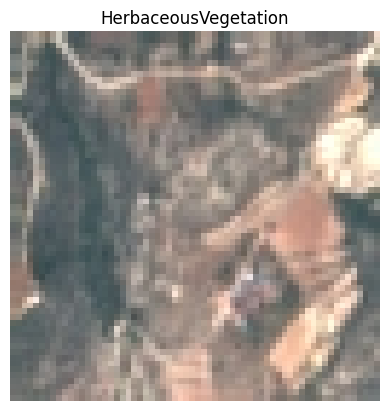

In [ ]:
if not local_run:
  dataset = tf.keras.preprocessing.image_dataset_from_directory(
      '/content/2750', image_size=(64, 64), batch_size=1, shuffle=True)

  for images, labels in dataset.take(1):
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.title(dataset.class_names[labels[0]])
    plt.axis("off")
    plt.show()

- Preprocessing dataset  

`transforms.ToTensor()` convert the image into PyTorch Tensor and scale automatically pixel from $0-255$ (int) to $0.0-1.0$ (float). The output is a tensor with the form of [Channel, Height, Wigth]: for RGB image $[3,
 64, 64]$, for grayscale image $[1, 64, 64]$.

 `transforms.Normalize` normalize the input tensor image = (image - mean) / std. The value for mean and std are standard value used for ImageNet dataset
([Site](https://discuss.pytorch.org/t/mean-and-std-values-for-transforms-normalize/70458)).


In [ ]:
transform = transforms.Compose([transforms.Resize((64, 64)), # resize imgs to 64x64 pixels
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])
                                ])

Load preprocessed dataset using `torchvision.datasets.ImageFolder` (PyTorch).

In [ ]:
eurosat_dataset = ImageFolder(img_path, transform=transform)
# eurosat_dataset = ImageFolder('/content/2750', transform=transform)

# Create train-test split
Use `torch.utils.data.random_split` (PyTorch) to split data into train and test set, with ratio 8:2, i.e., keep 20% of the whole dataset for testing the trained global model later.

In [ ]:
dataset_size = len(eurosat_dataset)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

train_dataset, test_dataset = random_split(eurosat_dataset, [train_size, test_size])

In [ ]:
# check len
print("Dataset size:", dataset_size)
print(f"Train dataset size: {len(train_dataset)}, Test size: {len(test_dataset)}")

Dataset size: 27000
Train dataset size: 21600, Test size: 5400


# Create clients & batch data

In [ ]:
def create_iid_clients(dataset, num_clients, seed):
  """
  Args:
      dataset (torch.utils.data.Dataset): full dataset
      num_clients (int): number of clients to create
      seed (int): seed for randomization

  Returns: a dictionary where keys are client names and
            values are Subset objects containing that client's data
  """
  np.random.seed(seed)

  # create list of client names with the prefix 'clients'
  client_names = [f'client_{i+1}' for i in range(num_clients)]

  # create random permutation of all dataset indices
  indices = np.random.permutation(len(dataset))

  # calculate how many samples each client should get
  size = len(dataset)//num_clients
  clients_dict = {}

  # split indices among clients
  for i, client_name in enumerate(client_names):
    start_idx = i * size
    # for the last client, take all remaining samples to cover the remainder
    if i == num_clients - 1:
      client_indices = indices[start_idx:]
    else:
      client_indices = indices[start_idx:start_idx + size]

    # create a Subset of the dataset for this client
    clients_dict[client_name] = Subset(dataset, client_indices)

  return clients_dict

In [ ]:
clients = create_iid_clients(train_dataset, num_clients, seed=42)

In [ ]:
print(type(clients))
print(clients.keys())

<class 'dict'>
dict_keys(['client_1', 'client_2', 'client_3', 'client_4', 'client_5', 'client_6', 'client_7', 'client_8', 'client_9', 'client_10'])


In [ ]:
for client, subset in clients.items():
    print(f"{client}: {len(subset)} elements")

client_1: 2160 elements
client_2: 2160 elements
client_3: 2160 elements
client_4: 2160 elements
client_5: 2160 elements
client_6: 2160 elements
client_7: 2160 elements
client_8: 2160 elements
client_9: 2160 elements
client_10: 2160 elements


In [ ]:
sample = clients['client_1'][0] # tuple (img tensor, label)
print("type:", type(sample))
print("img shape:", sample[0].shape)
print("label:", sample[1])

type: <class 'tuple'>
img shape: torch.Size([3, 64, 64])
label: 2


- Batch data using `torch.utils.data.DataLoader`.

In [ ]:
if local_run:
  num_workers = 0
else:
  num_workers = 2

In [ ]:
def batch_data(data_shard, batch_size):
    return DataLoader(data_shard, batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

In [ ]:
clients_batched = {
    client_name: batch_data(client_data, batch_size)
    for client_name, client_data in clients.items()
    }

In [ ]:
# check len
expected_batches = math.ceil(2160/32)
print("Expected batches:", expected_batches)
num_batches = len(clients_batched['client_1'])
print("Number of batches for client_1:", num_batches)

Expected batches: 68
Number of batches for client_1: 68


Process and bathc test set using `torch.utils.data.DataLoader`.

In [ ]:
test_batched = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

# Create model
Create CNN model using `torch.nn.Sequential`.

In [ ]:
def build_cnn_model(in_chan, classes):
  model = torch.nn.Sequential(
    torch.nn.Conv2d(in_chan, 32, kernel_size=3, padding=1), # 32=hyperparameter (32, 64, 128, 256)
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2, 2),

    torch.nn.Conv2d(32, 64, kernel_size=3, padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2, 2),

    torch.nn.Conv2d(64, 128, kernel_size=3, padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2, 2),

    torch.nn.Flatten(),
    torch.nn.Linear(128*8*8, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, classes)
    )
  return model

In [ ]:
eurosat_dataset[0][0].shape

torch.Size([3, 64, 64])

Create CNN model.

The RGB images of EuroSAT dataset have dim. $[3, 64, 64]$, so the initial channel has dimension $3$ and number of classes is $10$.

In [ ]:
cnn_model = build_cnn_model(in_chan=3, classes=10).to(device)

`.to(device)`transfers model's parameters to the specified device (like GPU, CPU): `device = torch.device("cuda" if torch.cuda.is_available() else "cpu")`, where `cuda` means GPU.
This ensures that both model and data are on the same device to avoid errors and to leverage hardware acceleration (GPU for faster computations).

In [ ]:
len(cnn_model)

13

In [ ]:
summary(cnn_model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
              ReLU-2           [-1, 32, 64, 64]               0
         MaxPool2d-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
              ReLU-5           [-1, 64, 32, 32]               0
         MaxPool2d-6           [-1, 64, 16, 16]               0
            Conv2d-7          [-1, 128, 16, 16]          73,856
              ReLU-8          [-1, 128, 16, 16]               0
         MaxPool2d-9            [-1, 128, 8, 8]               0
          Flatten-10                 [-1, 8192]               0
           Linear-11                  [-1, 256]       2,097,408
             ReLU-12                  [-1, 256]               0
           Linear-13                   [-1, 10]           2,570
Total params: 2,193,226
Trainable param

In output shape $-1$ represents the batch size.

Check the parameters: e.g. for `Conv2d-1`:
-  `kernel_size` $=3$ means $3\times 3$ matrix
- input channel is $3$ (RGB image)
- output channel is $32$

In [ ]:
# Conv2d-1
print((3*3*3+1)*32) # +1 bias
# Conv2d-4
print((3*3*32+1)*64)
# Conv2d-7
print((3*3*64+1)*128)

896
18496
73856


In [ ]:
# Fully connected layers:
# Linear-11
print((128*8*8+1)*256) # (in+1)*out
# Linear-13
print((256+1)*10) # (in+1)*classes

2097408
2570


In [ ]:
896+18496+73856+2097408+2570

2193226

- Define function `model_fn`

In [ ]:
model_fn = lambda: build_cnn_model(in_chan=3, classes=10)

# FL utility functions (PyTorch)

In [ ]:
def sum_scaled_weights(scaled_weight_list):
  """
  Sums all clients' scaled local weights.
  Args: list of lists of tensors (one list per client),
        where each sublist contains tensors for each layer.
  Returns: list of tensors representing the sum of weights layer-wise.
  """
  avg_weights = []
  for layer_weights in zip(*scaled_weight_list):
    avg_weights.append(torch.sum(torch.stack(layer_weights), dim=0))
  return avg_weights

In [ ]:
def from_real_to_complex(vct_real):
  """
  Args: list of real Tensor.
        Each Tensor is a matrix (n_row, n_col), where n_row is always even numb.
  Returns: list of complex Tensor, with same dimension of input list

  Given the real-valued vector (component of Tensor) of length n_row,
  the output complex vector has lenght n_row/2,
  by mapping pairs pf consecutive elements to the real and imaginary parts of each complex entry.
  The k-th complex component is vect_real[2*k] + i*vect_real[2*k+1].
  If input Tensor is a matrix, this transformation is applied to each column.
  """
  vct_complex = []
  for comp in vct_real:
      if comp.ndim == 1:
        new = torch.complex(comp[::2], comp[1::2])
      else:
        new = torch.complex(comp[::2, :], comp[1::2, :])
      vct_complex.append(new)
  return vct_complex

In [ ]:
def from_complex_to_real(vct_complex):
  """
    Args: list of complex Tensor.
          Each Tensor is a matrix (n_row, n_col), where n_row is the number of complex rows.
    Returns: list of real Tensor, with same number of columns but twice the number of rows.

    Given a complex-valued vector of length n_row,
    the output real vector has length n_row by splitting the real and imaginary parts
    into consecutive positions in the output tensor.
    If the input Tensor is a matrix, the transformation is applied to each column.
    """
  vct_real = []
  for comp in vct_complex:
    if comp.ndim == 1:
      new = torch.stack([comp.real, comp.imag], dim=1).reshape(-1)
    else:
      stacked = torch.stack((torch.real(comp), torch.imag(comp)), dim=1)
      new = stacked.reshape(2 * comp.shape[0], *comp.shape[1:]) # *comp.shape[1:]
    vct_real.append(new)
  return vct_real

`generate_complex_rand_tensor` function create random Tensor with normally distributed elements. This function is used to generate both the complex random channel vector $h$ and the noise vector $n$.

$h$ is modeled as a complex random variable with mean $1.0$ and standard deviation $\sigma_h$.

$n$ is modeled as a complex random variable with mean $0.0$ and standard deviation $\sigma_n$.

When generating both $h$ and $n$, the real part has mean $1.0$ for $h$ and $0.0$ for $n$, whereas the imaginary component is symmetric around zero, so mean is fixed to $0.0$.

In [ ]:
def generate_complex_rand_tensor(in_list, mean, sd):
  """
  Create random Tensor with normally distributed elements with the same size of input tensor
  Args: in_list: input list of tensors
        mean (float): Mean of the normal distribution
        sd (float): Standard deviation of the normal distribution
  Returns: complex-valued list of tensors, with the same size of input tensor
  """
  out_list = []
  for comp in in_list:
    real_part = torch.normal(mean=mean, std=sd, size=comp.shape, device=comp.device) #
    imag_part = torch.normal(mean=0.0, std=sd, size=comp.shape, device=comp.device)
    out_list.append(torch.complex(real_part, imag_part))
  return out_list

# Training centralized FL function
- `comms_round` = 100
- `chan_check` = True, is the fading case, where the channel vector is a complex random variable; while `chan_check`= False is the no fading case, where the channel is equal to 1 $\forall t$
- `noise_check`= True means that the noise is complex random vector, otherwise is equal to zero
- `training_ideal_test_ota` = True is the ideal case tested via OTA.  

Note that if `training_ideal_test_ota` = True, also `chan_check` and `noise_check` are True.
- `model_fn`

In [ ]:
def training_FedAvg_OTA(comms_round, lr, loss_fn, model_fn,
                        clients_batched, test_batched,
                        local_optimizer = 'SGD',
                        chan_check=False, chan_mean=1.0, chan_sd=None,
                        noise_check=False, noise_mean=0.0, noise_sd=None,
                        training_ideal_test_ota=False, seed=1234,
                        device='cuda' if torch.cuda.is_available() else 'cpu',
                        betas=(0.9,0.999), grad_clipping=False): # for 'Adam' local opt. analysis

  # set seed for replicability
  np.random.seed(seed)
  random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

  global_model = model_fn().to(device)
  global_count = sum(len(loader.dataset) for loader in clients_batched.values()) # 21600 train set

  acc_history, loss_history = [], [] # empty list for plots

  for t in range(comms_round):
    # copy initial weights of global model
    global_weights = deepcopy([p.data.clone() for p in global_model.parameters()])
    scaled_local_weights = [] # initial list to collect local model weights after scaling

    # randomize client data by keys
    client_names = list(clients_batched.keys())
    random.shuffle(client_names)

    for client in client_names: # iterate through training client
      local_model = model_fn().to(device)
      # set local model weights to global model weights
      local_model.load_state_dict(global_model.state_dict())

      if local_optimizer == 'SGD':
        optimizer = torch.optim.SGD(local_model.parameters(), lr=lr, momentum=0.9,
                                    weight_decay=lr/comms_round)
      elif local_optimizer == 'Adam':
        optimizer = torch.optim.Adam(local_model.parameters(), lr=lr, betas=betas, eps=1e-08)
      else: raise ValueError(f"Optimizer '{local_optimizer}' not supported.")

      local_model.train()
      for images, labels in clients_batched[client]:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = local_model(images)
        loss = loss_fn(output, labels)
        loss.backward()
        if grad_clipping:
          torch.nn.utils.clip_grad_norm_(local_model.parameters(), max_norm=1.0)
        optimizer.step()

      # get the tot number of data points held by a client
      local_count = len(clients_batched[client].dataset)

      # transform weights' var from real to Complex
      # create a detached copy of model param. to avoid interfering with backpropagation
      local_weights_real = [p.data.clone().detach().cpu() for p in local_model.parameters()] # .parameters() get weights
      local_weights_complex = from_real_to_complex(local_weights_real)

      # FL case:
      if not training_ideal_test_ota:
        # add complex (random) channel vector
        if chan_check: # FL via OTA case
          chan_vec = generate_complex_rand_tensor(local_weights_complex, chan_mean, chan_sd)

        else:# ideal FL case
          chan_vec = [torch.complex(torch.tensor(1.0), torch.tensor(0.0))] * len(local_weights_complex)

        scaled_weights = [chan_vec[i]*local_weights_complex[i]*local_count for i in range(len(local_weights_complex))]

      else: # training_ideal_test_ota=True
        scaled_weights = [w*local_count for w in local_weights_complex]

      scaled_local_weights.append(scaled_weights)

      # clear session to free memory after each comm round
      del local_model # to delete local_model var
      torch.cuda.empty_cache() # free unused GPU memory
      gc.collect() # garbage collector: to clean memory

    # get average over all local model, sum of scaled weights
    average_weights = [(1.0 / global_count) * w for w in sum_scaled_weights(scaled_local_weights)]

    if training_ideal_test_ota: # apply channel to average weights
      chan_vec = generate_complex_rand_tensor(average_weights, chan_mean, chan_sd)
      average_weights = [chan_vec[i] * average_weights[i] for i in range(len(average_weights))]

    # add complex random noise
    if noise_check:
      noise = generate_complex_rand_tensor(average_weights, noise_mean, noise_sd)
      AirComp_average_weights = [average_weights[i] + noise[i] for i in range(len(average_weights))]
    else:
      AirComp_average_weights = average_weights

    # back to Real number
    AirComp_average_weights_real = from_complex_to_real(AirComp_average_weights)

    # update global model
    for param, new_w in zip(global_model.parameters(), AirComp_average_weights_real):
      param.data = new_w.to(device)

    # test global model and print metrics
    global_model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
      for X_test_batch, y_test_batch in test_batched:
        X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
        outputs = global_model(X_test_batch)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_test_batch.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    loss_value = loss_fn(outputs, y_test_batch).item()

    print(f"round {t+1} | global accuracy: {acc:.3%} | loss: {loss_value:.4f}")
    acc_history.append(acc)
    loss_history.append(loss_value)

  return acc_history, loss_history

# Federated Learning
Train FL considered as a specific case of FL via over-the-air in which:
- channel vector is equal to a constant unitary: `chan_check=False`
- noise vectors is zero: `noise_check=False`
- `training_ideal_test_ota=False`
- `local_optimizer=SGD`

In [ ]:
learning_rate = 0.01

In [ ]:
acc_fl, loss_fl = training_FedAvg_OTA(comms_round, learning_rate, loss, model_fn,
                                      clients_batched, test_batched,
                                      chan_check=False, noise_check=False)

write_results_to_txt_file('file_out_eurosat_acc_fl', acc_fl, out_path)
write_results_to_txt_file('file_out_eurosat_loss_fl', loss_fl, out_path)

- Plot

In [ ]:
acc_fl = read_results_from_txt_file('file_out_eurosat_acc_fl', out_path)
loss_fl = read_results_from_txt_file('file_out_eurosat_loss_fl', out_path)

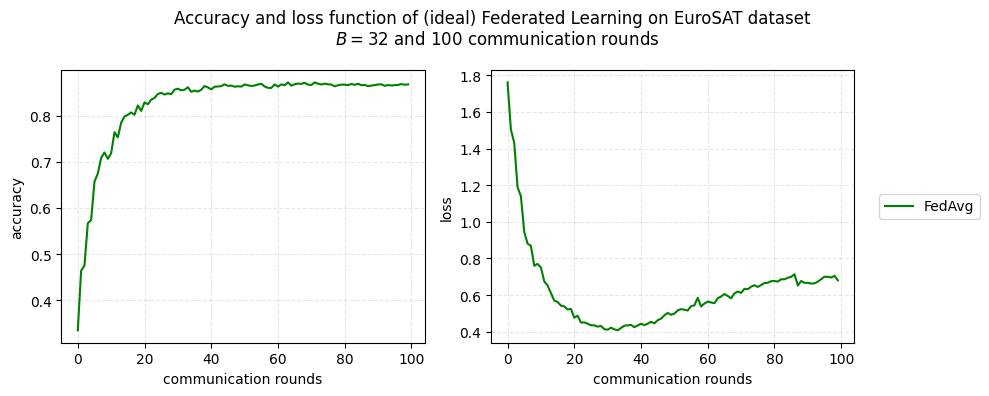

In [ ]:
plot_save_acc_loss_fct(acc_fl, loss_fl, 'FedAvg',
                       'Accuracy and loss function of (ideal) Federated Learning on EuroSAT dataset \n $B=32$ and $100$ communication rounds',
                       plot_path, 'acc_loss_fl')

# FL via over-the-air (SGD)

## No fading case
The channel vector $h$ is constant: $h_i^t =1$ $\forall t$ communication round.

- `chan_check` = False: no fading
- `noise_check` = True: noise is complex random vector with normal distribution, mean $0.0$ and standard deviation
   - `noise_sd`$=0.01$
   - `noise_sd`$=0.02$
   - `noise_sd`$=0.03$
   - `noise_sd`$=0.04$

In [ ]:
noise_sd = ['0.01', '0.02', '0.03', '0.04']
noise_keys = {h: h.replace('.', '') for h in noise_sd}

- Training

In [ ]:
for i in range(len(noise_sd)):
 print(f'Start training no fading for noise std {noise_sd[i]}')
 acc_, loss_ = training_FedAvg_OTA(comms_round, learning_rate, loss, model_fn,
                                   clients_batched, test_batched, chan_check=False,
                                   noise_check=True, noise_sd=float(noise_sd[i]))
 write_results_to_txt_file(f'file_out_eurosat_acc_{noise_keys[noise_sd[i]]}', acc_, out_path)
 write_results_to_txt_file(f'file_out_eurosat_loss_{noise_keys[noise_sd[i]]}', loss_, out_path)

- Comparison plots

Loading accuracy and loss no fading case from `.txt` files and plotting the results.

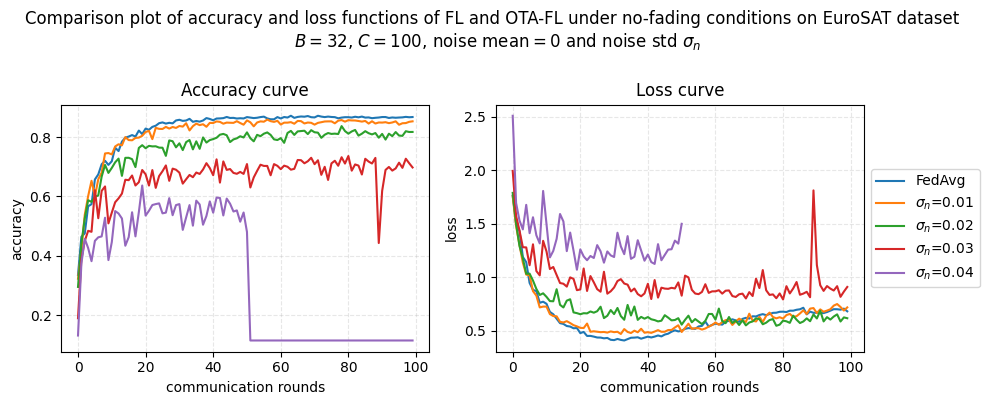

In [ ]:
plt.figure(figsize=(10,4))
plt.suptitle('Comparison plot of accuracy and loss functions of FL and OTA-FL under no-fading conditions on EuroSAT dataset \n $B=32$, $C=100$, noise mean$=0$ and noise std $\\sigma_n$',
             fontsize=12, y=1)
# accuracy curves
plt.subplot(1,2,1)
acc_fl = read_results_from_txt_file('file_out_eurosat_acc_fl', out_path) # plot (ideal) FedAvg
lets_plot(acc_fl, label='FedAvg')

for i in  range(len(noise_sd)): # plot no fading
  res_acc = read_results_from_txt_file(f'file_out_eurosat_acc_{noise_keys[noise_sd[i]]}', out_path)
  lets_plot(res_acc, label=fr"$\sigma_n$={float(noise_sd[i])}",
            title='Accuracy curve', ylabel='accuracy')

# loss curves
plt.subplot(1,2,2)
loss_fl = read_results_from_txt_file('file_out_eurosat_loss_fl', out_path) # plot (ideal) FedAvg
lets_plot(loss_fl, label='FedAvg')

for i in range(len(noise_sd)): # plot no fading
  res_loss = read_results_from_txt_file(f'file_out_eurosat_loss_{noise_keys[noise_sd[i]]}', out_path)
  lets_plot(res_loss, label=fr"$\sigma_n$={float(noise_sd[i])}",
            title='Loss curve', ylabel='loss')

plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
save_plot(plot_path, 'acc_loss_no_fading_comparison')

## FL via OTA w/ fading
The channel is complex normal distributed $h\sim NC(1,\sigma_h^2)$ and the noise has a complex normal distribution $n\sim NC(0, \sigma_n^2)$.

- `chan_check` = True: fading case, with mean `chan_mean`$=1.0$ and standard deviation `chan_sd` $\sigma_h$
- `noise_check` = True: with mean `noise_mean`$=0.0$ and standard deviation `noise_sd` $\sigma_n$
- `training_ideal_test_ota` = False



In [ ]:
chan_sd = ['0.1', '0.15', '0.2', '0.25', '0.3']
noise_sd = ['0.01', '0.015', '0.0175', '0.02', '0.03']

### Functions

In [ ]:
def sintax_txt_file(local_optimizer, grad_clip):
  if local_optimizer not in ['SGD', 'Adam']:
    raise ValueError(f"Optimizer '{local_optimizer}' not supported.")

  optimizer_suffix = "_adam" if local_optimizer == "Adam" else ""
  if local_optimizer == "Adam" and grad_clip:
    optimizer_suffix = "_clipAdam"

  return optimizer_suffix

In [ ]:
def train_ota_and_write_results(comms_round, learning_rate, loss_fn, model_fn,
                                clients_batched, test_batched,
                                local_optimizer='SGD',
                                chan_sd=None, noise_sd=None,
                                grad_clip=False, betas=(0.9,0.999), out_path=None):
  acc_ota, loss_ota = {}, {}
  chan_keys = {h: h.replace('.', '') for h in chan_sd}
  noise_keys = {h: h.replace('.', '') for h in noise_sd}

  for h in chan_sd:
    chan_key = chan_keys[h]
    acc_ota[h] = {}
    loss_ota[h] = {}

    for n in noise_sd:
      print(f"Start training for chan std {h} and noise std {n}")
      noise_key = noise_keys[n]
      ota_acc, ota_loss = training_FedAvg_OTA(comms_round, learning_rate, loss_fn, model_fn,
                                              clients_batched, test_batched, local_optimizer=local_optimizer,
                                              chan_check=True, chan_sd=float(h),
                                              noise_check=True, noise_sd=float(n),
                                              training_ideal_test_ota=False,
                                              betas=betas, grad_clipping=grad_clip)
      acc_ota[h][n] = ota_acc
      loss_ota[h][n] = ota_loss

      # write accuracy and loss results on .txt files
      optimizer_suffix = sintax_txt_file(local_optimizer, grad_clip)

      acc_file = f"file_out_eurosat_acc_{chan_key}_{noise_key}{optimizer_suffix}"
      loss_file = f"file_out_eurosat_loss_{chan_key}_{noise_key}{optimizer_suffix}"

      write_results_to_txt_file(acc_file, ota_acc, out_path)
      write_results_to_txt_file(loss_file, ota_loss, out_path)
      print(f"Results saved on {acc_file}.txt and {loss_file}.txt")

  return acc_ota, loss_ota

In [ ]:
def load_ota_results(chan_sd, noise_sd, local_optimizer='SGD', grad_clip=False, out_path=None):
  acc_ota, loss_ota = {}, {}
  chan_keys = {h: h.replace('.', '') for h in chan_sd}
  noise_keys = {h: h.replace('.', '') for h in noise_sd}

  optimizer_suffix = sintax_txt_file(local_optimizer, grad_clip)

  for h in chan_sd:
    chan_key = chan_keys[h]
    acc_ota[h] = {}
    loss_ota[h] = {}
    for n in noise_sd:
      noise_key = noise_keys[n]
      acc_ota[h][n] = read_results_from_txt_file(f"file_out_eurosat_acc_{chan_key}_{noise_key}{optimizer_suffix}", out_path)
      loss_ota[h][n] = read_results_from_txt_file(f"file_out_eurosat_loss_{chan_key}_{noise_key}{optimizer_suffix}", out_path)

  return acc_ota, loss_ota

In [ ]:
def plot_acc_loss_ota(chan_sd, noise_fixed, acc_ota, loss_ota, title=None):
  ''' Args: chan_sd: lst of channel std values
            noise_fixed (str): value of fixed noise std
            acc_ota, loss_ota (dict): dicts with accuracy and loss functions
            title (str, optional): title of plot
      Returns: plot of accuracy and loss functions and save into .png file
  '''
  if title is None:
    title = (f'Federated Learning OTA: accuracy & loss over comm. rounds\n'
             f'EuroSAT — fixed noise std $\\sigma_n$={noise_fixed}, variable channel std $\\sigma_h$')

  plt.figure(figsize=(10,4))
  plt.suptitle(title, fontsize=12, y=1)

  # accuracy plot
  plt.subplot(1,2,1)
  lets_plot(acc_fl, label='FedAvg')
  for h in chan_sd:
    lets_plot(acc_ota[h][noise_fixed], label=fr"$\sigma_h$={float(h)}", title='Accuracy curve', ylabel='accuracy')

  # loss plot
  plt.subplot(1,2,2)
  lets_plot(loss_fl, label='FedAvg')
  for h in chan_sd:
    lets_plot(loss_ota[h][noise_fixed], label=fr"$\sigma_h$={float(h)}", title='Loss curve', ylabel='loss')

  plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
  noise_key = noise_fixed.replace('.', '')
  save_plot(plot_path, f'acc_loss_ota_comparison_{noise_key}')

### Training

In [ ]:
fixed_noise_sd = ['']

- train with fixed `noise_sd` to $0.01$ and plot the results

In [ ]:
fixed_noise_sd[0] = noise_sd[0]
print('Start training for fixed noise std:', fixed_noise_sd[0])

Start training for fixed noise std: 0.01


In [ ]:
_, _ = train_ota_and_write_results(comms_round, learning_rate, loss, model_fn,
                                   clients_batched, test_batched,
                                   chan_sd=chan_sd, noise_sd=fixed_noise_sd, out_path=out_path)

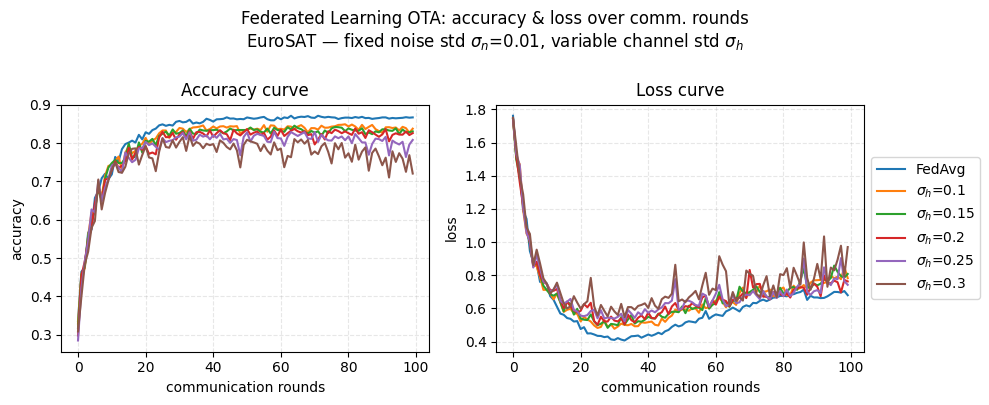

In [ ]:
acc_dict_001, loss_dict_001 = load_ota_results(chan_sd, fixed_noise_sd, out_path=out_path)
plot_acc_loss_ota(chan_sd, fixed_noise_sd[0], acc_dict_001,  loss_dict_001)

- train with fixed `noise_sd`$=0.015$ and plot the results

In [ ]:
fixed_noise_sd[0] = noise_sd[1]
print('Start training for fixed noise std:', fixed_noise_sd[0])

Start training for fixed noise std: 0.015


In [ ]:
_, _ = train_ota_and_write_results(comms_round, learning_rate, loss, model_fn,
                                   clients_batched, test_batched,
                                   chan_sd=chan_sd, noise_sd=fixed_noise_sd, out_path=out_path)

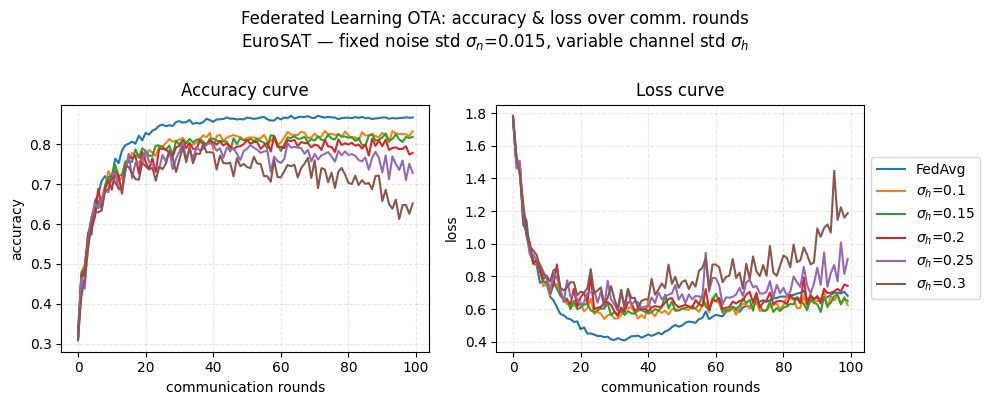

In [ ]:
acc_dict_0015, loss_dict_0015 = load_ota_results(chan_sd, fixed_noise_sd, out_path=out_path)
plot_acc_loss_ota(chan_sd, fixed_noise_sd[0], acc_dict_0015, loss_dict_0015)

- train with fixed `noise_sd`$=0.0175$ and plot the results

In [ ]:
fixed_noise_sd[0] = noise_sd[2]
print('Start training for fixed noise std:', fixed_noise_sd[0])

Start training for fixed noise std: 0.0175


In [ ]:
_, _ = train_ota_and_write_results(comms_round, learning_rate, loss, model_fn,
                                   clients_batched, test_batched,
                                   chan_sd=chan_sd, noise_sd=fixed_noise_sd, out_path=out_path)

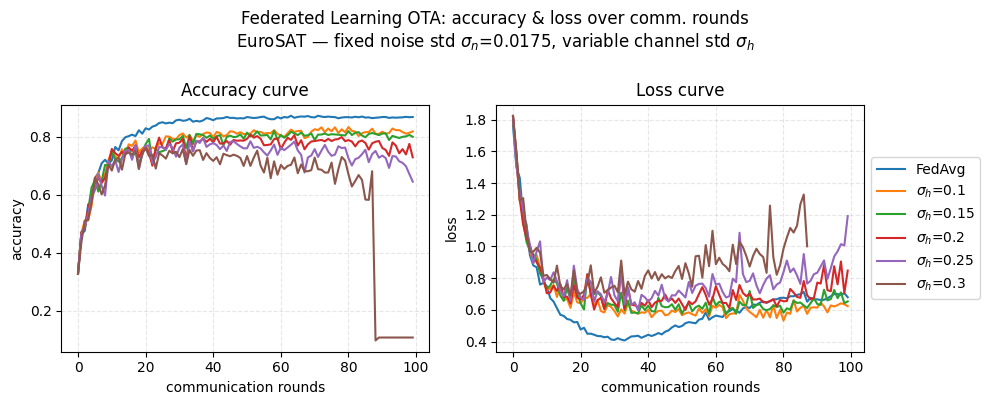

In [ ]:
acc_dict_00175, loss_dict_00175 = load_ota_results(chan_sd, fixed_noise_sd, out_path=out_path)
plot_acc_loss_ota(chan_sd, fixed_noise_sd[0], acc_dict_00175, loss_dict_00175)

- train with fixed `noise_sd`$=0.02$ and plot the results

In [ ]:
fixed_noise_sd[0] = noise_sd[3]
print('Start training for fixed noise std:', fixed_noise_sd[0])

Start training for fixed noise std: 0.02


In [ ]:
_, _ = train_ota_and_write_results(comms_round, learning_rate, loss, model_fn,
                                   clients_batched, test_batched,
                                   chan_sd=chan_sd, noise_sd=fixed_noise_sd, out_path=out_path)

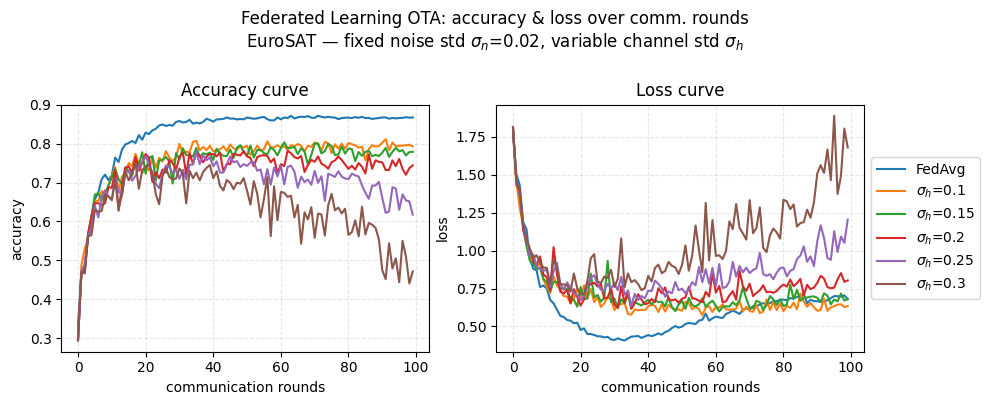

In [ ]:
acc_dict_002, loss_dict_002 = load_ota_results(chan_sd, fixed_noise_sd, out_path=out_path)
plot_acc_loss_ota(chan_sd, fixed_noise_sd[0], acc_dict_002, loss_dict_002)

- train with fixed `noise_sd`$=0.03$ and plot the results

In [ ]:
fixed_noise_sd[0] = noise_sd[4]
print('Start training for fixed noise std:', fixed_noise_sd[0])

Start training for fixed noise std: 0.03


In [ ]:
_, _ = train_ota_and_write_results(comms_round, learning_rate, loss, model_fn,
                                   clients_batched, test_batched,
                                   chan_sd=chan_sd, noise_sd=fixed_noise_sd, out_path=out_path)

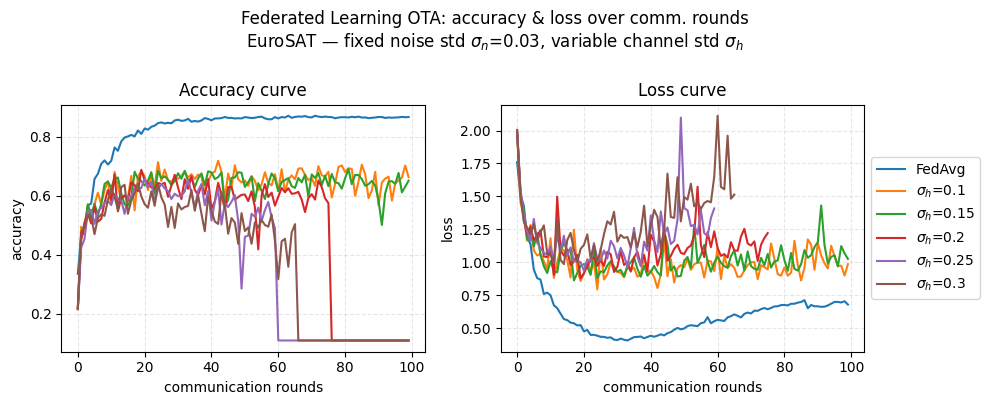

In [ ]:
acc_dict_003, loss_dict_003 = load_ota_results(chan_sd, fixed_noise_sd, out_path=out_path)
plot_acc_loss_ota(chan_sd, fixed_noise_sd[0], acc_dict_003, loss_dict_003)

### Resulting plot & table


- Table

Resulting table of accuracy wrt the variation of noise and channel standard deviation $\sigma_n$ and $\sigma_h$, respectively (row-cols).

In [ ]:
acc_res, _ = load_ota_results(chan_sd, noise_sd, out_path=out_path)
acc_res = [ [round(acc_res[chan][noise][-1], 3) for chan in chan_sd] for noise in noise_sd]

df_SGD = pd.DataFrame(np.array(acc_res), index=[f"σₙ={n}" for n in noise_sd], columns=[f"σₕ={h}" for h in chan_sd])
df_SGD

σₕ=0.1  σₕ=0.15  σₕ=0.2  σₕ=0.25  σₕ=0.3
σₙ=0.01     0.838    0.831   0.826    0.809   0.721
σₙ=0.015    0.833    0.819   0.779    0.728   0.652
σₙ=0.0175   0.818    0.799   0.744    0.645   0.593
σₙ=0.02     0.793    0.779   0.713    0.617   0.471
σₙ=0.03     0.663    0.651   0.109    0.109   0.109

- Resulting plot

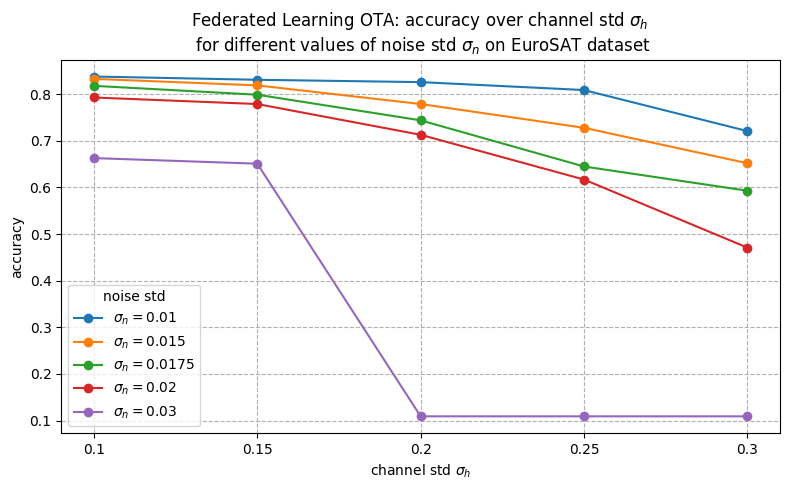

In [ ]:
plt.figure(figsize=(8, 5))
for i, sn in enumerate(noise_sd):
  plt.plot(chan_sd, acc_res[i], marker='o', label=rf'$\sigma_n = {sn}$')

plt.xlabel(r'channel std $\sigma_h$')
plt.ylabel('accuracy')
plt.title('Federated Learning OTA: accuracy over channel std $\sigma_h$ \n for different values of noise std $\sigma_n$ on EuroSAT dataset', y=1)
plt.legend(title='noise std')
plt.grid(True, linestyle='--')
plt.tight_layout()

save_plot(plot_path, 'final_ota_acc_comparison')

- $\sigma_n=0.03$ is too high: the accuracy completely collapses, indicating that the noise overwhelms the aggregated signal
- $\sigma_h$ has less impact than $\sigma_n$, but there's still noticeable degradation, especially when $\sigma_n=0.02$ and $\sigma_h=0.3$
- The behavior appears non-linear: small increases in $\sigma_n$ or $\sigma_h$ result in very different impacts depending on the starting point.

## FL with ideal training and test over-the-air
This section analyse the ideal case evaluated over-the-air, where the model performs a perfect aggregation of local updates without any channel-induced distortion. Then, fading and noise are applied to the aggregated model to simulate transmission through a wireless channel.


- `chan_check` = True
- `noise_check` = True
- `training_ideal_test_ota` = True

In [ ]:
tes_chan_sd = ['0.1', '0.15', '0.2']
tes_noise_sd = ['0.01', '0.015', '0.0175']

chan_keys = {h: h.replace('.', '') for h in tes_chan_sd}
noise_keys = {h: h.replace('.', '') for h in tes_noise_sd}

Run ideal-training-test-OTA case for 3 couples of chan-noise std: $(0.1, 0.01), (0.15, 0.015), (0.2, 0.0175)$.

In [ ]:
for i in  range(len(tes_chan_sd)):
  print(f"Start training for chan std {tes_chan_sd[i]} and noise std {tes_noise_sd[i]}")
  ota_acc, ota_loss = training_FedAvg_OTA(comms_round, learning_rate, loss,
                                          model_fn, clients_batched, test_batched,
                                          chan_check=True, chan_sd=float(tes_chan_sd[i]),
                                          noise_check=True, noise_sd=float(tes_noise_sd[i]),
                                          training_ideal_test_ota=True)

  write_results_to_txt_file(f'file_out_eurosat_ideal_test_acc_{chan_keys[tes_chan_sd[i]]}_{noise_keys[tes_noise_sd[i]]}', ota_acc, out_path)
  write_results_to_txt_file(f'file_out_eurosat_ideal_test_loss_{chan_keys[tes_chan_sd[i]]}_{noise_keys[tes_noise_sd[i]]}', ota_loss, out_path)

## Final comparison plots

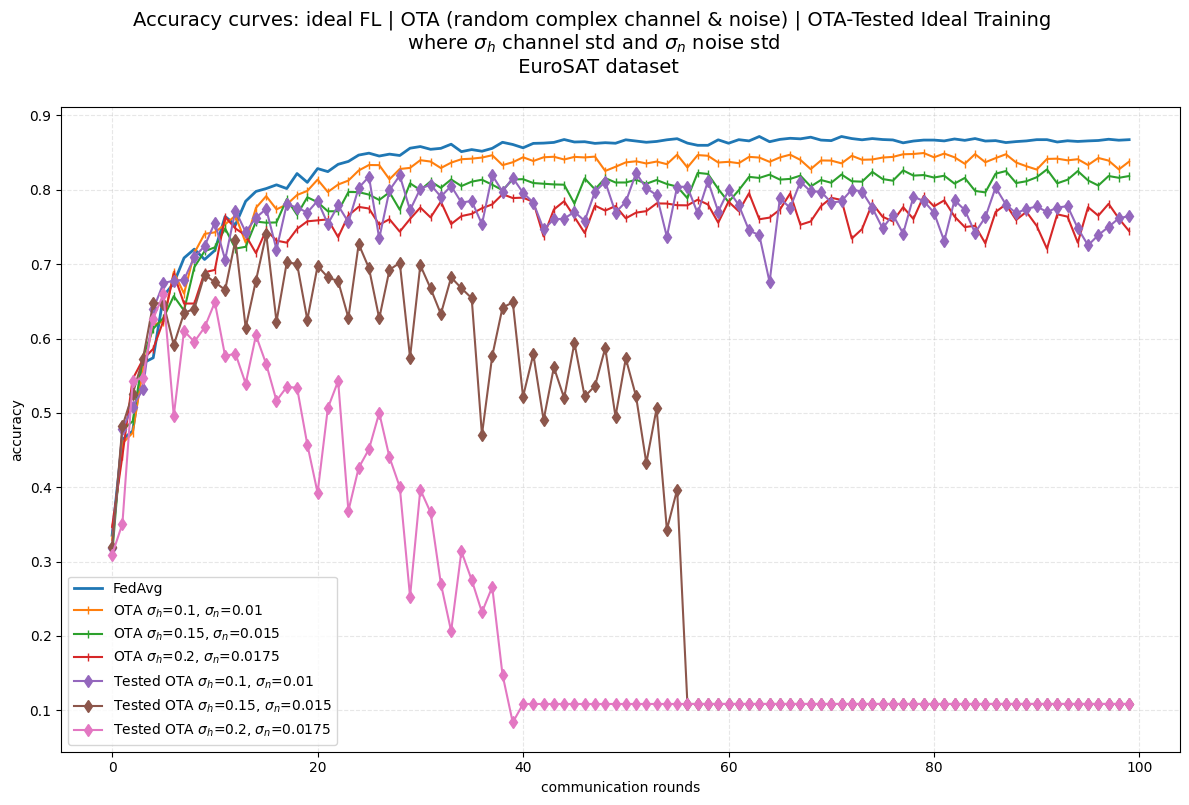

In [ ]:
plt.figure(figsize=(12,8))
plt.suptitle('Accuracy curves: ideal FL | OTA (random complex channel & noise) | OTA-Tested Ideal Training \n where $\sigma_h$ channel std and $\sigma_n$ noise std  \n EuroSAT dataset',
             fontsize=14, y=1)
# Plot (ideal) FedAvg
acc_fl = read_results_from_txt_file('file_out_eurosat_acc_fl', out_path)
lets_plot(acc_fl, label='FedAvg', lw=2)

# Plot OTA cases
for i in  range(len(tes_chan_sd)):
  ota_acc = read_results_from_txt_file(f'file_out_eurosat_acc_{chan_keys[tes_chan_sd[i]]}_{noise_keys[tes_noise_sd[i]]}', out_path)
  lets_plot(ota_acc, label=fr"OTA $\sigma_h$={float(tes_chan_sd[i])}, $\sigma_n$={float(tes_noise_sd[i])}",
            ylabel='accuracy', marker='|')

# Plot ideal training tested OTA cases
for i in  range(len(tes_chan_sd)):
  res_acc = read_results_from_txt_file(f'file_out_eurosat_ideal_test_acc_{chan_keys[tes_chan_sd[i]]}_{noise_keys[tes_noise_sd[i]]}', out_path)
  lets_plot(res_acc, label=fr"Tested OTA $\sigma_h$={float(tes_chan_sd[i])}, $\sigma_n$={float(tes_noise_sd[i])}",
            ylabel='accuracy', marker='d')
plt.legend()
save_plot(plot_path, 'final_comparison')

# Federated Learning (Adam)
- `local_optimizer = Adam`

In [ ]:
# set learning rate for Adam
lr = 0.001

In [ ]:
acc_fl_adam, loss_fl_adam = training_FedAvg_OTA(comms_round, lr, loss, model_fn,
                                                clients_batched, test_batched,
                                                local_optimizer = 'Adam',
                                                chan_check=False, noise_check=False)

write_results_to_txt_file('file_out_eurosat_acc_fl_adam', acc_fl, out_path)
write_results_to_txt_file('file_out_eurosat_loss_fl_adam', loss_fl, out_path)

In [ ]:
acc_fl_adam = read_results_from_txt_file('file_out_eurosat_acc_fl_adam', out_path)
loss_fl_adam = read_results_from_txt_file('file_out_eurosat_loss_fl_adam', out_path)

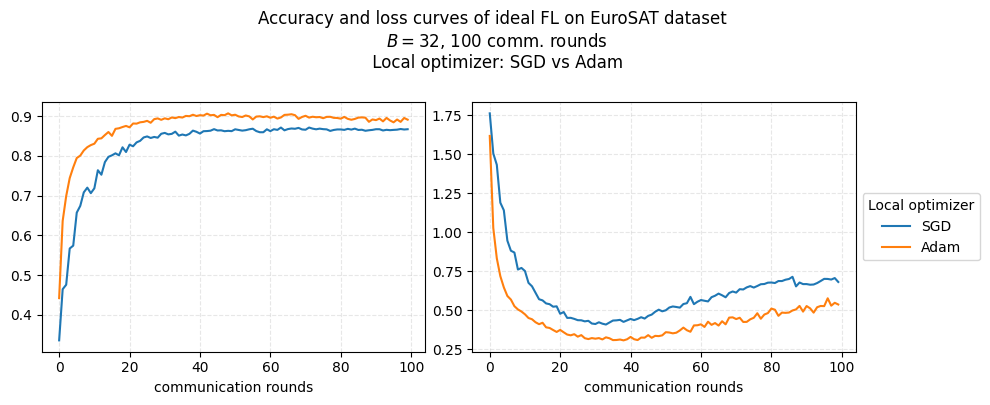

In [ ]:
plt.figure(figsize=(10,4))
plt.suptitle('Accuracy and loss curves of ideal FL on EuroSAT dataset \n $B=32$, $100$ comm. rounds \n Local optimizer: SGD vs Adam',
             fontsize=12, y=1)
plt.subplot(1,2,1)
lets_plot(acc_fl)
lets_plot(acc_fl_adam)
plt.subplot(1,2,2)
lets_plot(loss_fl, label='SGD')
lets_plot(loss_fl_adam, label='Adam')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5), title='Local optimizer')
save_plot(plot_path, 'acc_loss_fl_sgdvsadam')

# FL via OTA w/fading (Adam)
- `chan_check` = True: fading case, with mean `chan_mean`$=1.0$ and standard deviation `chan_sd` $\sigma_h$
- `noise_check` = True: with mean `noise_mean`$=0.0$ and standard deviation `noise_sd` $\sigma_n$
- `training_ideal_test_ota` = False
- `local_optimizer` = Adam

In [ ]:
chan_sd = ['0.1', '0.15', '0.2', '0.25', '0.3']
noise_sd = ['0.01', '0.015', '0.0175', '0.02']

chan_keys = {h: h.replace('.', '') for h in chan_sd}
noise_keys = {h: h.replace('.', '') for h in noise_sd}

Training and plot of OTA with Adam local optimizer with default hyperparameters:
- `lr`$=0.001$
- `betas`$=(0.9, 0.999)$

In [ ]:
_, _ = train_ota_and_write_results(comms_round, lr, loss, model_fn,
                                   clients_batched, test_batched, local_optimizer='Adam',
                                   chan_sd=chan_sd, noise_sd=noise_sd, out_path=out_path)

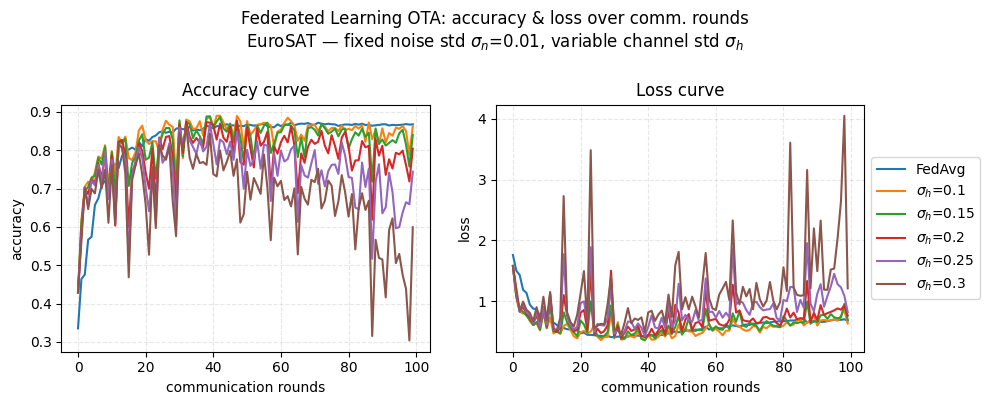

In [ ]:
res_acc, res_loss = load_ota_results(chan_sd, [noise_sd[0]], local_optimizer='Adam', out_path=out_path)
plot_acc_loss_ota(chan_sd, noise_sd[0], res_acc, res_loss)

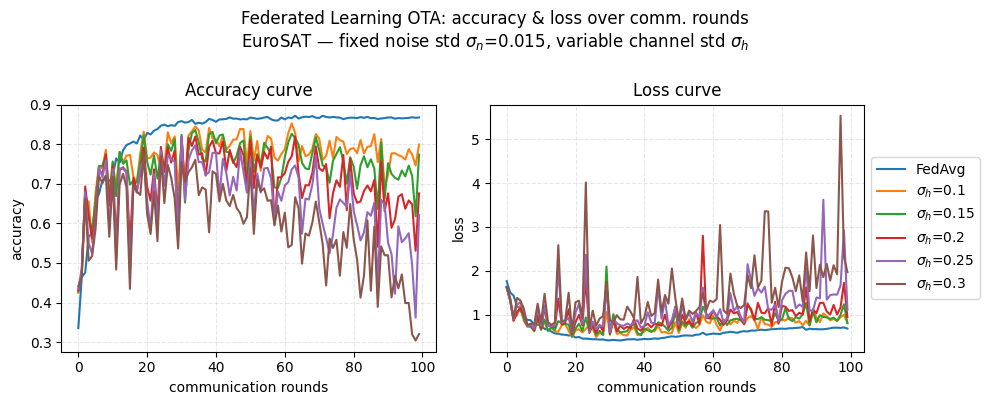

In [ ]:
res_acc, res_loss = load_ota_results(chan_sd, [noise_sd[1]], local_optimizer='Adam', out_path=out_path)
plot_acc_loss_ota(chan_sd, noise_sd[1], res_acc, res_loss)

In [ ]:
res_acc, res_loss = load_ota_results(chan_sd, [noise_sd[2]], local_optimizer='Adam', out_path=out_path)
plot_acc_loss_ota(chan_sd, noise_sd[2], res_acc, res_loss)

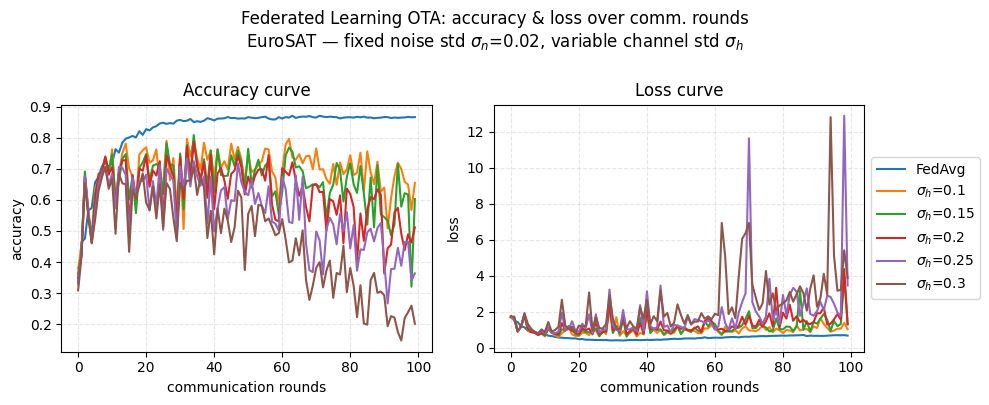

In [ ]:
res_acc, res_loss = load_ota_results(chan_sd, [noise_sd[3]], local_optimizer='Adam', out_path=out_path)
plot_acc_loss_ota(chan_sd, noise_sd[3], res_acc, res_loss)

- Resulting table

In [ ]:
acc_res_adam, _ = load_ota_results(chan_sd, noise_sd, local_optimizer='Adam', out_path=out_path)
acc_res_adam = [ [round(acc_res_adam[chan][noise][-1], 3) for chan in chan_sd] for noise in noise_sd]

pd.DataFrame(np.array(acc_res_adam), index=[f"σₙ={n}" for n in noise_sd], columns=[f"σₕ={h}" for h in chan_sd])

σₕ=0.1  σₕ=0.15  σₕ=0.2  σₕ=0.25  σₕ=0.3
σₙ=0.01     0.863    0.840   0.804    0.744   0.599
σₙ=0.015    0.799    0.774   0.676    0.621   0.321
σₙ=0.0175   0.758    0.660   0.600    0.466   0.265
σₙ=0.02     0.655    0.603   0.512    0.364   0.201

- Resulting plot

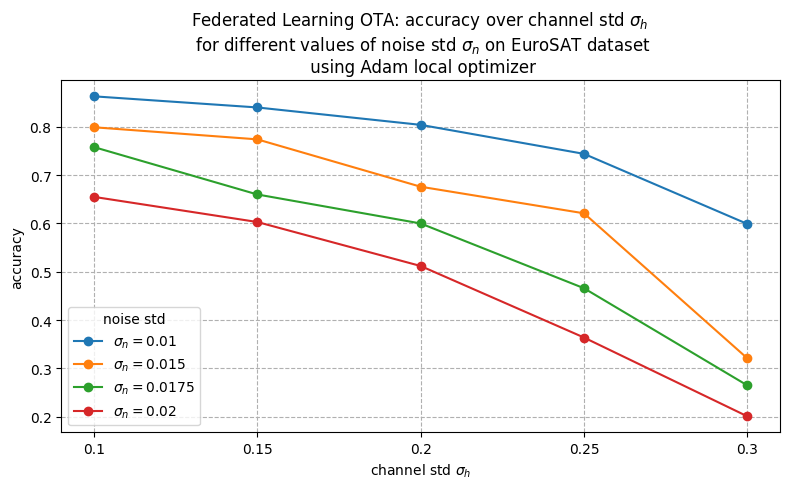

In [ ]:
plt.figure(figsize=(8, 5))
for i, sn in enumerate(noise_sd):
    plt.plot(chan_sd, acc_res_adam[i], marker='o', label=rf'$\sigma_n = {sn}$')

plt.xlabel(r'channel std $\sigma_h$')
plt.ylabel('accuracy')
plt.title('Federated Learning OTA: accuracy over channel std $\sigma_h$ \n for different values of noise std $\sigma_n$ on EuroSAT dataset \n using Adam local optimizer', y=1)
plt.legend(title='noise std')
plt.grid(True, linestyle='--')
plt.tight_layout()

save_plot(plot_path, 'final_ota_acc_comparison_adam')

# Comparision local optimized: SGD vs Adam

- Accuracy

In [ ]:
acc_res, _ = load_ota_results(chan_sd, noise_sd, out_path=out_path)
acc_res_adam, _ = load_ota_results(chan_sd, noise_sd, local_optimizer='Adam', out_path=out_path)

In [ ]:
target_accuracy = 0.80

In [ ]:
df_conv_SGD = pd.DataFrame(pd.NA, index=[f"σₙ={n}" for n in noise_sd], columns=[f"σₕ={h}" for h in chan_sd])
df_conv_adam = pd.DataFrame(pd.NA, index=[f"σₙ={n}" for n in noise_sd], columns=[f"σₕ={h}" for h in chan_sd])

In [ ]:
for h in acc_res.keys():
  for n in acc_res[h].keys():
    for i, line in enumerate(acc_res[h][n]):
      if acc_res[h][n][i] >= target_accuracy:
        df_conv_SGD.loc[f"σₙ={n}", f"σₕ={h}"] = i
        break
df_conv_SGD

σₕ=0.1 σₕ=0.15 σₕ=0.2 σₕ=0.25 σₕ=0.3
σₙ=0.01       20      18     24      20     25
σₙ=0.015      26      29     31      31     37
σₙ=0.0175     26      31   <NA>    <NA>   <NA>
σₙ=0.02       34      61   <NA>    <NA>   <NA>

In [ ]:
for h in acc_res_adam.keys():
  for n in acc_res_adam[h].keys():
    for i, line in enumerate(acc_res[h][n]):
      if acc_res_adam[h][n][i] >= target_accuracy:
        df_conv_adam.loc[f"σₙ={n}", f"σₕ={h}"] = i
        break
df_conv_adam

σₕ=0.1 σₕ=0.15 σₕ=0.2 σₕ=0.25 σₕ=0.3
σₙ=0.01        8       8     12      12     12
σₙ=0.015      19      19     30      30   <NA>
σₙ=0.0175     26      26     32      27   <NA>
σₙ=0.02     <NA>      34   <NA>    <NA>   <NA>

- Plots

In [ ]:
n_rows = len(chan_sd)
n_cols = len(noise_sd)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3.5 * n_rows), sharex=True, sharey=True)
fig.suptitle('Accuracy curves: OTA (SGD vs Adam) — EuroSAT\n'
             r'$\sigma_h$ channel std (row), $\sigma_n$ noise std (col)', fontsize=16, y=1.02)

for i, h in enumerate(chan_sd):
  for j, n in enumerate(noise_sd):
    ax = axes[i, j] if n_rows > 1 else axes[j]
    # SGD
    ota_acc = read_results_from_txt_file(f'file_out_eurosat_acc_{chan_keys[h]}_{noise_keys[n]}', out_path)
    x = np.arange(len(ota_acc))
    l1, = ax.plot(x, ota_acc, label="SGD",  color='C0', linewidth=2)
    ax.annotate(f"{ota_acc[-1]:.2f}",(x[-1], ota_acc[-1]), textcoords="offset points", xytext=(-15, +5), fontsize=7,
                color='C0', bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.6))

    # Adam
    acc_adam = read_results_from_txt_file(f'file_out_eurosat_acc_{chan_keys[h]}_{noise_keys[n]}_adam', out_path)
    l2, = ax.plot(x, acc_adam, label="Adam", color='C1', linewidth=2)
    ax.annotate(f"{acc_adam[-1]:.2f}",(x[-1], acc_adam[-1]), textcoords="offset points", xytext=(-15, -10), fontsize=7,
                color='C1', bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.6))

    ax.set_title(rf"$\sigma_h$={h}, $\sigma_n$={n}", fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.3)
    if i == n_rows - 1:
        ax.set_xlabel("Communication rounds")
    if j == 0:
        ax.set_ylabel("Accuracy")

handles = [l1, l2]
labels  = [h.get_label() for h in handles]
fig.subplots_adjust(right=0.85)

fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 0.5), frameon=True,
           title="Optimizer", fontsize=9, title_fontsize=10, borderpad=0.5, labelspacing=0.4)
plt.tight_layout(rect=[0, 0, 0.84, 0.96])

save_plot(plot_path, 'subplot_sgd_vs_adam')
plt.show()

## Training Adam - new hyperparameter

**Change learning rate and betas**

Training and plot of OTA with Adam local optimizer with  hyperparameters:
- `lr`$=0.0005$
- `betas`$=(0.8, 0.999)$

In [ ]:
lr = 0.0005

In [ ]:
acc_, loss_ = training_FedAvg_OTA(comms_round, lr, loss, model_fn,
                                  clients_batched, test_batched, local_optimizer = 'Adam',
                                  chan_check=True, chan_mean=chan_mean, chan_sd=['0.1'],
                                  noise_check=True, noise_mean=noise_mean, noise_sd=['0.0175'],
                                  betas=(0.8,0.999))

write_results_to_txt_file(f'file_out_eurosat_acc_01_00175_adam2', acc_, out_path)
write_results_to_txt_file(f'file_out_eurosat_loss_01_00175_adam2', loss_, out_path)

In [ ]:
acc_, loss_ = training_FedAvg_OTA(comms_round, lr, loss, model_fn,
                                  clients_batched, test_batched, local_optimizer = 'Adam',
                                  chan_check=True, chan_mean=chan_mean, chan_sd=['0.25'],
                                  noise_check=True, noise_mean=noise_mean, noise_sd=['0.015'],
                                  betas=(0.8,0.999))

write_results_to_txt_file(f'file_out_eurosat_acc_025_0015_adam2', acc_, out_path)
write_results_to_txt_file(f'file_out_eurosat_loss_025_0015_adam2', loss_, out_path)

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
acc_adam2_01_00175 = read_results_from_txt_file(f'file_out_eurosat_acc_01_00175_adam2', out_path)
acc_adam_01_00175 = read_results_from_txt_file(f'file_out_eurosat_acc_01_00175_adam', out_path)
lets_plot(acc_adam2_01_00175, label=fr"$\eta=0.0005$, $(\beta_1,\beta_2)=(0.8, 0.999)$",ylabel='accuracy', marker='d')
lets_plot(acc_adam_01_00175, label=fr"$\eta=0.001$, $(\beta_1,\beta_2)=(0.99, 0.999)$", ylabel='accuracy',
          title=r'$\sigma_h=0.1$ and $\sigma_n=0.0175$', marker='x')

plt.subplot(1,2,2)
acc_adam2_025_0015 = read_results_from_txt_file(f'file_out_eurosat_acc_025_0015_adam2', out_path)
acc_adam_025_0015 = read_results_from_txt_file(f'file_out_eurosat_acc_025_0015_adam', out_path)
lets_plot(acc_adam2_01_00175, label=fr"$\eta=0.0005$, $(\beta_1,\beta_2)=(0.8, 0.999)$",ylabel='accuracy', marker='d')
lets_plot(acc_adam_025_0015, label=fr"$\eta=0.001$, $(\beta_1,\beta_2)=(0.99, 0.999)$", ylabel='accuracy',
          title=r'$\sigma_h=0.25$ and $\sigma_n=0.015$', marker='x')
plt.legend(fontsize=10, loc='lower right')
plt.suptitle('OTA Adam accuracy curves with different parameters \n on EuroSAT dataset',
             fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

**Gradient clipping**

Training and plot of OTA with Adam local optimizer:
- `lr`$=0.0005$
- `betas`$=(0.8, 0.999)$
- `grad_clipping=True`

In [ ]:
acc_clip_01_00175, _ = train_ota_and_write_results(comms_round, 0.0005, loss, model_fn,
                                                   clients_batched, test_batched, local_optimizer='Adam',
                                                   chan_mean=chan_mean, chan_sd=['0.1'],
                                                   noise_mean=noise_mean, noise_sd=['0.0175'],
                                                   grad_clip=True, betas=(0.8, 0.999), out_path=out_path)

In [ ]:
acc_clip_025_0015, _ = train_ota_and_write_results(comms_round, 0.0005, loss, model_fn,
                                                   clients_batched, test_batched, local_optimizer='Adam',
                                                   chan_mean=chan_mean, chan_sd=['0.25'],
                                                   noise_mean=noise_mean, noise_sd=['0.015'],
                                                   grad_clip=True, betas=(0.8, 0.999), out_path=out_path)

- Comparing accuracy plots

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.suptitle('OTA Adam accuracy curves with different parameters \n on EuroSAT dataset', fontsize=14, y=1)

acc_adam_01_00175 = read_results_from_txt_file(f'file_out_eurosat_acc_01_00175_adam', out_path)
acc_adam2_01_00175 = read_results_from_txt_file(f'file_out_eurosat_acc_01_00175_adam2', out_path)
acc_clip_01_00175 = read_results_from_txt_file(f'file_out_eurosat_acc_01_00175_clipAdam', out_path)
lets_plot(acc_adam_01_00175, label=fr"$\eta=0.001, \beta=(0.99, 0.999)$")
lets_plot(acc_adam2_01_00175, label=fr"$\eta=0.0005, \beta=(0.8, 0.999)$")
lets_plot(acc_clip_01_00175, label=fr"$\eta=0.0005, \beta=(0.8, 0.999)$ + grad.clipping", ylabel='accuracy', title=r'$\sigma_h = 0.1$, $\sigma_n = 0.0175$')

plt.subplot(1,2,2)
acc_adam_025_0015 = read_results_from_txt_file(f'file_out_eurosat_acc_025_0015_adam', out_path)
acc_adam2_025_0015 = read_results_from_txt_file(f'file_out_eurosat_acc_025_0015_adam2', out_path)
acc_clip_025_0015 = read_results_from_txt_file(f'file_out_eurosat_acc_025_0015_clipAdam', out_path)
lets_plot(acc_adam_025_0015, label=fr"$\eta=0.001, \beta=(0.99, 0.999)$")
lets_plot(acc_adam2_025_0015, label=fr"$\eta=0.0005, \beta=(0.8, 0.999)$")
lets_plot(acc_clip_025_0015, label=fr"$\eta=0.0005, \beta=(0.8, 0.999)$ + grad.clipping", title=r'$\sigma_h=0.25$ and $\sigma_n=0.015$', lnstl='-.')

plt.legend(fontsize=10, loc='lower right')
plt.tight_layout()
plt.show()


# Decentralized FL
- `local_optimizer = SGD`

Define $W\in \mathbb R^{N \times N}$ as the **mixing matrix** where $N$ is the numb. of clients. Each entry $W_{ij}$ defines the weight client $i$ assigns to the model of neighbor client $j$ during aggregation. $W$ is symmetric, stochastic (rows sum to $1$) and it is consistent with the network graph topology.

In [ ]:
def build_metropolis_matrix(G):
  n = len(G.nodes)
  W = np.zeros((n, n))
  for i in G.nodes:
    for j in G.neighbors(i):
      W[i][j] = 1 / (1 + max(G.degree[i], G.degree[j]))
  for i in G.nodes:
    W[i][i] = 1 - np.sum(W[i])
  return torch.tensor(W, dtype=torch.float32)

Compute second eigenvalue of Laplacian matrix.

Laplacian matrix $L$ of an unweighted graof is defined as $L=D-A$, where $A$ is the adjacency matrix and $D$ is the degree matrix (diagonal matrix where $D_{ii}$ equals the degree of node $i$). $L$ is symmetric, positive semidefinite, and its eigenvalues encode import connectivity properties of the graph.

Laplacian matrix $L$ of a weighted graph is def as $L=D-W$, where $W$ is the weighted adjacency matrix containing the edge weights, and $D$ is the weighted degree matrix with $D_{ii}=\sum_j W_{ij}$.

In the consensus setting with a Metropolis matrix $W$, the Laplacian is given by $L=I-W$, where $W$ is row-stochastic (each row sums to one) and defines the averaging dynamica between connected nodes.

In [ ]:
from scipy.linalg import eigvalsh

def compute_lambda2(G):
  W = build_metropolis_matrix(G)
  # compute Laplacian matrix D - W
  L = np.eye(W.shape[0]) - W.numpy() # W.shape[0] = num. nodes
  eigenvalues = eigvalsh(L) # compute eigenvalues, Real part, ordered
  return eigenvalues[1] # return second eigenvalue λ₂

## Function
Function `training_distributed_FedAvg_OTA` each client updates its model using only neighbours' models, with mixing matrix as `adjacency_matrix`.
- `chan_mean` $=1.0$ and `noise_mean` $=0.0$

In [ ]:
def training_Distributed_FedAvg_OTA(comms_rounds, lr, loss_fn, model_fn,
                                    clients_batched, test_batched, adjacency_matrix,
                                    chan_mean=1.0, chan_std=None, noise_mean=0.0, noise_std=None,
                                    seed=1234, device='cuda' if torch.cuda.is_available() else 'cpu'):
  # set seed for replicability
  np.random.seed(seed)
  random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

  client_names = list(clients_batched.keys()) # list with clients' names
  num_clients = len(client_names) # 10 clients
  # create local model for each client
  local_models = [model_fn().to(device) for _ in range(num_clients)]
  for model in local_models:
    model.load_state_dict(model_fn().state_dict())

  history_acc, history_loss = [], []

  for rnd in range(comms_rounds):
    local_weights = []
    # local train for each client
    for i, client_name in enumerate(client_names):
      loader = clients_batched[client_name]
      local_model = local_models[i]
      optimizer = torch.optim.SGD(local_model.parameters(), lr=lr, momentum=0.9)
      local_model.train()

      for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = local_model(x)
        loss = loss_fn(out, y)
        loss.backward()
        optimizer.step()

      # convert weights into complex random tensor
      local_weights_real = [p.data.clone().detach().cpu() for p in local_model.parameters()]
      local_weights_complex = from_real_to_complex(local_weights_real)
      chan = generate_complex_rand_tensor(local_weights_complex, mean=1.0, sd=chan_std) # apply complex random channel
      local_weights_complex = [chan[i] * local_weights_complex[i] for i in range(len(chan))]
      local_weights.append(local_weights_complex)

    ## decentralized aggregation step ##
    # each client updates its local model as weighted sum of neighbours
    new_local_weights = []
    for i in range(num_clients):
      mixed = []
      for l in range(len(local_weights[0])): # l = layer model
        agg = torch.zeros_like(local_weights[0][l])
        for j in range(num_clients):
          agg += adjacency_matrix[i, j] * local_weights[j][l]
        mixed.append(agg)
      # add complex random noise
      noise = generate_complex_rand_tensor(mixed, mean=0.0, sd=noise_std)
      mixed = [mixed[k] + noise[k] for k in range(len(mixed))]
      new_local_weights.append(from_complex_to_real(mixed)) # transform weights into real

    # update local model parameters with new weights
    for i in range(num_clients):
      for p, w in zip(local_models[i].parameters(), new_local_weights[i]):
        p.data = w.to(device)

    # create new global model for evaluation
    global_model = model_fn().to(device)
    global_state_dict = global_model.state_dict()

    avg_state_dict = {}
    for key in global_state_dict.keys():
      stacked = torch.stack([local_models[i].state_dict()[key].float().cpu() for i in range(num_clients)], dim=0)
      avg_state_dict[key] = torch.mean(stacked, dim=0)
    global_model.load_state_dict(avg_state_dict)
    global_model.eval()

    correct, total = 0, 0
    total_loss = 0.0
    with torch.no_grad():
      for x, y in test_batched:
        x, y = x.to(device), y.to(device)
        out = global_model(x)
        preds = out.argmax(dim=1)
        correct += (preds==y).sum().item()
        total += y.size(0)
        loss_batch = loss_fn(out, y).item()
        total_loss += loss_batch*y.size(0)

    acc = correct/total
    loss_val = total_loss / total
    print(f"round {rnd+1} | global accuracy: {acc:.3%} | loss: {loss_val:.4f}")
    history_acc.append(acc)
    history_loss.append(loss_val)

  return history_acc, history_loss

## Training: Erdos-Renyi graph


In [ ]:
chan_sd  = ['0.1',  '0.15',  '0.2',    '0.25', '0.3',    '0.3']
noise_sd = ['0.01', '0.015', '0.0175', '0.02', '0.0175', '0.03']

In [ ]:
lr = 0.01
graph_p = [0.1, 0.3, 0.6, 0.9]

`graph_p` is the probability of connection in Erdös-Renyi to generate the distributed topology:
- `graph_p`$=1$: totally connected graph
- `graph_p`$\sim 0$: sparse graph (no connection)
- `graph_p`$\sim \log(N)/N$

In [ ]:
def generate_connected_graph(num_nodes, graph_p, seed=None):
  rng = np.random.default_rng(seed)  # create a NumPy generator replicable
  while True:
    G = nx.erdos_renyi_graph(num_nodes, graph_p, seed=rng)
    if nx.is_connected(G):
        return G


- `graph_p`$=0.3$

In [ ]:
p = graph_p[1]
print(f"Start training graph_connectivity: p = {p}")

Start training graph_connectivity: p = 0.3


In [ ]:
G = generate_connected_graph(num_clients, p, seed=42)
W = build_metropolis_matrix(G)
print(f"Second eigenvalue λ₂: {compute_lambda2(G):.4f}")

pos = nx.spring_layout(G)#, seed=42)
plt.figure(figsize=(5, 5), dpi=300)
nx.draw_networkx_nodes(G, pos, node_size=600, node_color="lightblue", edgecolors="black", linewidths=0.8)
nx.draw_networkx_edges(G, pos, width=1.0, edge_color="gray")
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")
#nx.draw(G, with_labels=True, node_color='skyblue')

plt.title(f"Example of connected Erdös-Renyi graph with p={p}", fontsize=10)
plt.show()

Second eigenvalue λ₂: 0.1501


In [ ]:
for i in range(len(chan_sd)):
  print(f"Start training for chan std {chan_sd[i]} and noise std {noise_sd[i]}")
  distr_acc, distr_loss_ = training_Distributed_FedAvg_OTA(comms_round, lr, loss, model_fn,
                                                            clients_batched, test_batched,
                                                            adjacency_matrix=W,
                                                            chan_std=float(chan_sd[i]), noise_std=float(noise_sd[i]))
  write_results_to_txt_file(f'file_out_eurosat_distr_{str(p).replace(".","")}_acc_{chan_sd[i].replace(".","")}_{noise_sd[i].replace(".","")}',
                            distr_acc, out_path)
  write_results_to_txt_file(f'file_out_eurosat_distr_{str(p).replace(".","")}_loss_{chan_sd[i].replace(".","")}_{noise_sd[i].replace(".","")}',
                            distr_acc, out_path)

- Resulting plots

In [ ]:
palette = plt.rcParams['axes.prop_cycle'].by_key()['color'] # generate default color palette

plt.figure(figsize=(12,8))
plt.suptitle(f'Accuracy curves: Distributed vs Centralized FL OTA \n Graph connectivity: p = {p}', fontsize=14)

for i in range(len(chan_sd)):
  col = palette[i % len(palette)]
  # Plot FL Star OTA cases
  centr_acc = read_results_from_txt_file(f'file_out_eurosat_acc_{chan_sd[i].replace(".","")}_{noise_sd[i].replace(".","")}', out_path)
  lets_plot(centr_acc, label=fr"Centr. $\sigma_h$={float(chan_sd[i])}, $\sigma_n$={float(noise_sd[i])}",
            color=col, ylabel='accuracy', marker='x')

  # Plot FL Distributed OTA cases
  distr_acc = read_results_from_txt_file(f'file_out_eurosat_distr_{str(p).replace(".","")}_acc_{chan_sd[i].replace(".","")}_{noise_sd[i].replace(".","")}',
                                         out_path)
  lets_plot(distr_acc, label=fr"Distr. $\sigma_h$={float(chan_sd[i])}, $\sigma_n$={float(noise_sd[i])}",
            color=col, ylabel='accuracy')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.11), ncol=3, fontsize=9)
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharex=True)
fig.suptitle(f'Accuracy curves: Distributed vs Centralized FL OTA \n Graph connectivity: p = {p}', fontsize=14, y=1)

for i, ax in enumerate(axes.flat):
  plt.sca(ax) # set axis

  # read and plot accuracy curves for star FL OTA
  centr_acc = read_results_from_txt_file(f'file_out_eurosat_acc_{chan_sd[i].replace(".","")}_{noise_sd[i].replace(".","")}', out_path)
  lets_plot(centr_acc, label=fr"Centralized", ylabel='accuracy', marker='x')

  # read and plot accuracy curves for distributed FL OTA
  distr_acc = read_results_from_txt_file(f'file_out_eurosat_distr_{str(p).replace(".","")}_acc_{chan_sd[i].replace(".","")}_{noise_sd[i].replace(".","")}',
                                         out_path)
  lets_plot(distr_acc, label=fr"Distributed", ylabel='accuracy', lw=2)

  # set the title for the current subplot
  plt.title(fr"$\sigma_h$={float(chan_sd[i])}, $\sigma_n$={float(noise_sd[i])}")
  plt.grid(True, linestyle='--', alpha=0.3)

for ax in axes[-1, :]: # add label for x axies only on the last row
  ax.set_xlabel("communication rounds")

fig.legend(["Centralized", "Distributed"], loc='upper right', bbox_to_anchor=(0.98, 0.98), borderaxespad=0.1)
plt.tight_layout(rect=[0, 0, 1, 0.97])
save_plot(plot_path, 'distrVScentrFLOTA')
plt.show()

Training on different `graph_p`
- $p=0.1, 0.6, 0.9$


In [ ]:
chan_sd = ['0.1', '0.25']
noise_sd = ['0.01', '0.02']

In [ ]:
G = generate_connected_graph(num_clients, graph_p[0], seed=42)
print(f"Second eigenvalue λ₂: {compute_lambda2(G):.4f}")

#nx.draw(G, with_labels=True, node_color='skyblue')
pos = nx.spring_layout(G)#, seed=42)
plt.figure(figsize=(5, 5), dpi=300)
nx.draw_networkx_nodes(G, pos, node_size=600, node_color="lightblue", edgecolors="black", linewidths=0.8)
nx.draw_networkx_edges(G, pos, width=1.0, edge_color="gray")
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")

plt.title(f"Example of connected Erdös-Renyi graph with p={graph_p[0]}", fontsize=10)
#plt.title(f"Connected Erdös-Renyi graph with p={graph_p[0]}")
plt.show()

Second eigenvalue λ₂: 0.0351


Second eigenvalue λ₂: 0.3304


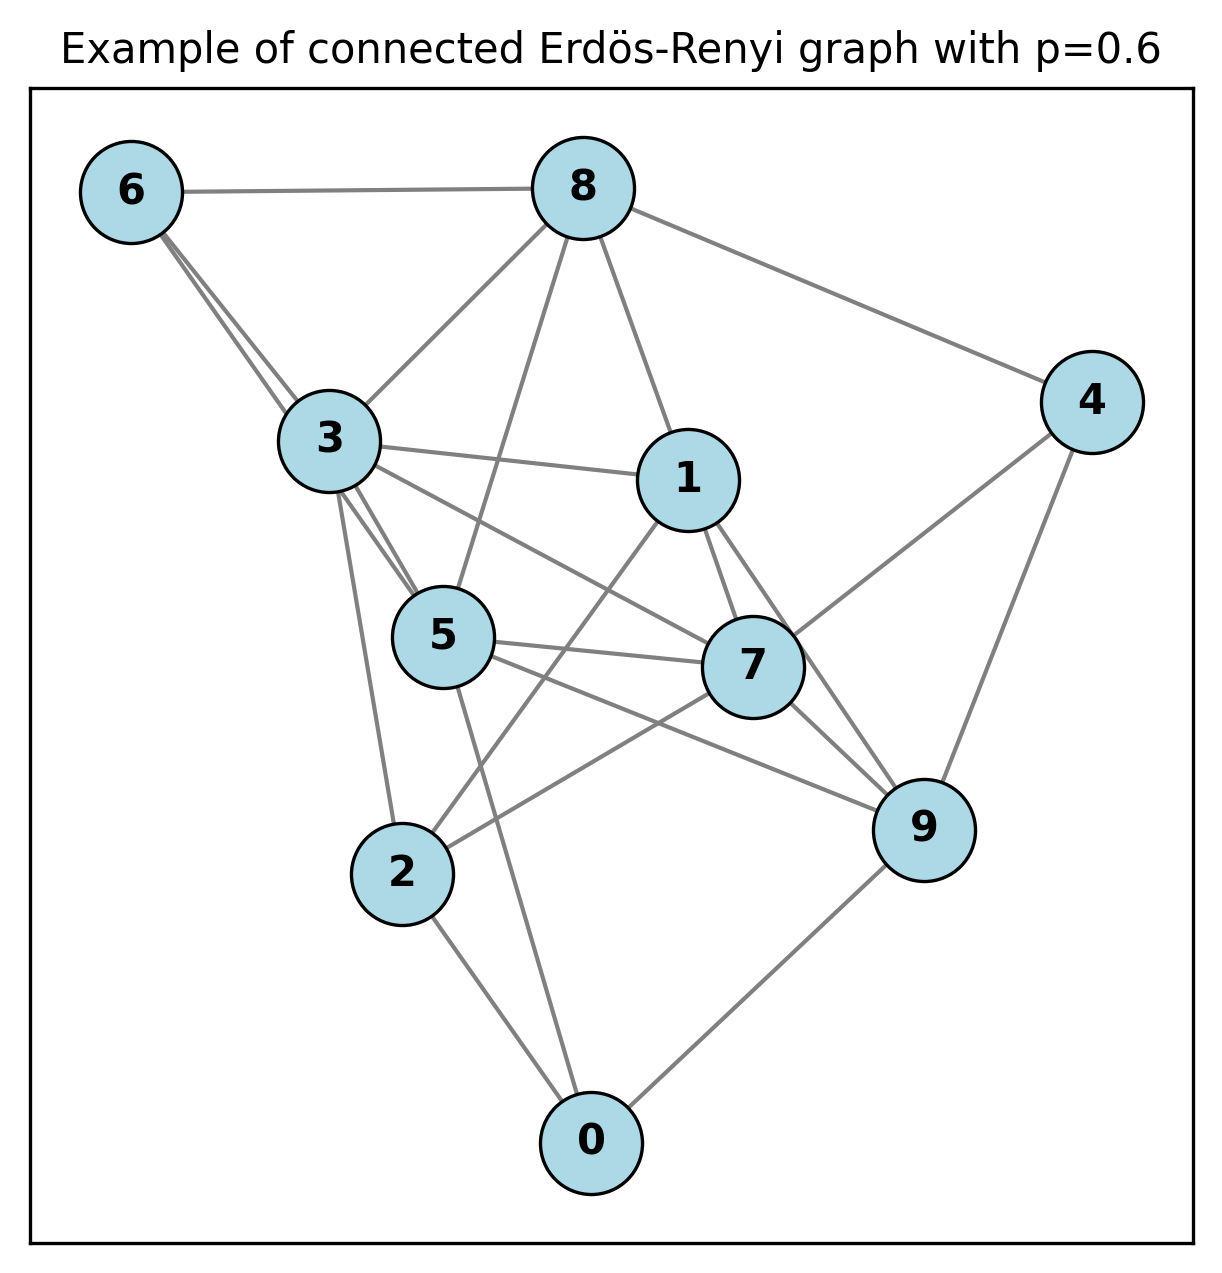

In [ ]:
G = generate_connected_graph(num_clients, graph_p[2], seed=42)
print(f"Second eigenvalue λ₂: {compute_lambda2(G):.4f}")

#nx.draw(G, with_labels=True, node_color='skyblue')
pos = nx.spring_layout(G)#, seed=42)
plt.figure(figsize=(5, 5), dpi=300)
nx.draw_networkx_nodes(G, pos, node_size=600, node_color="lightblue", edgecolors="black", linewidths=0.8)
nx.draw_networkx_edges(G, pos, width=1.0, edge_color="gray")
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")

plt.title(f"Example of connected Erdös-Renyi graph with p={graph_p[2]}", fontsize=10)
plt.show()

Second eigenvalue λ₂: 0.6873


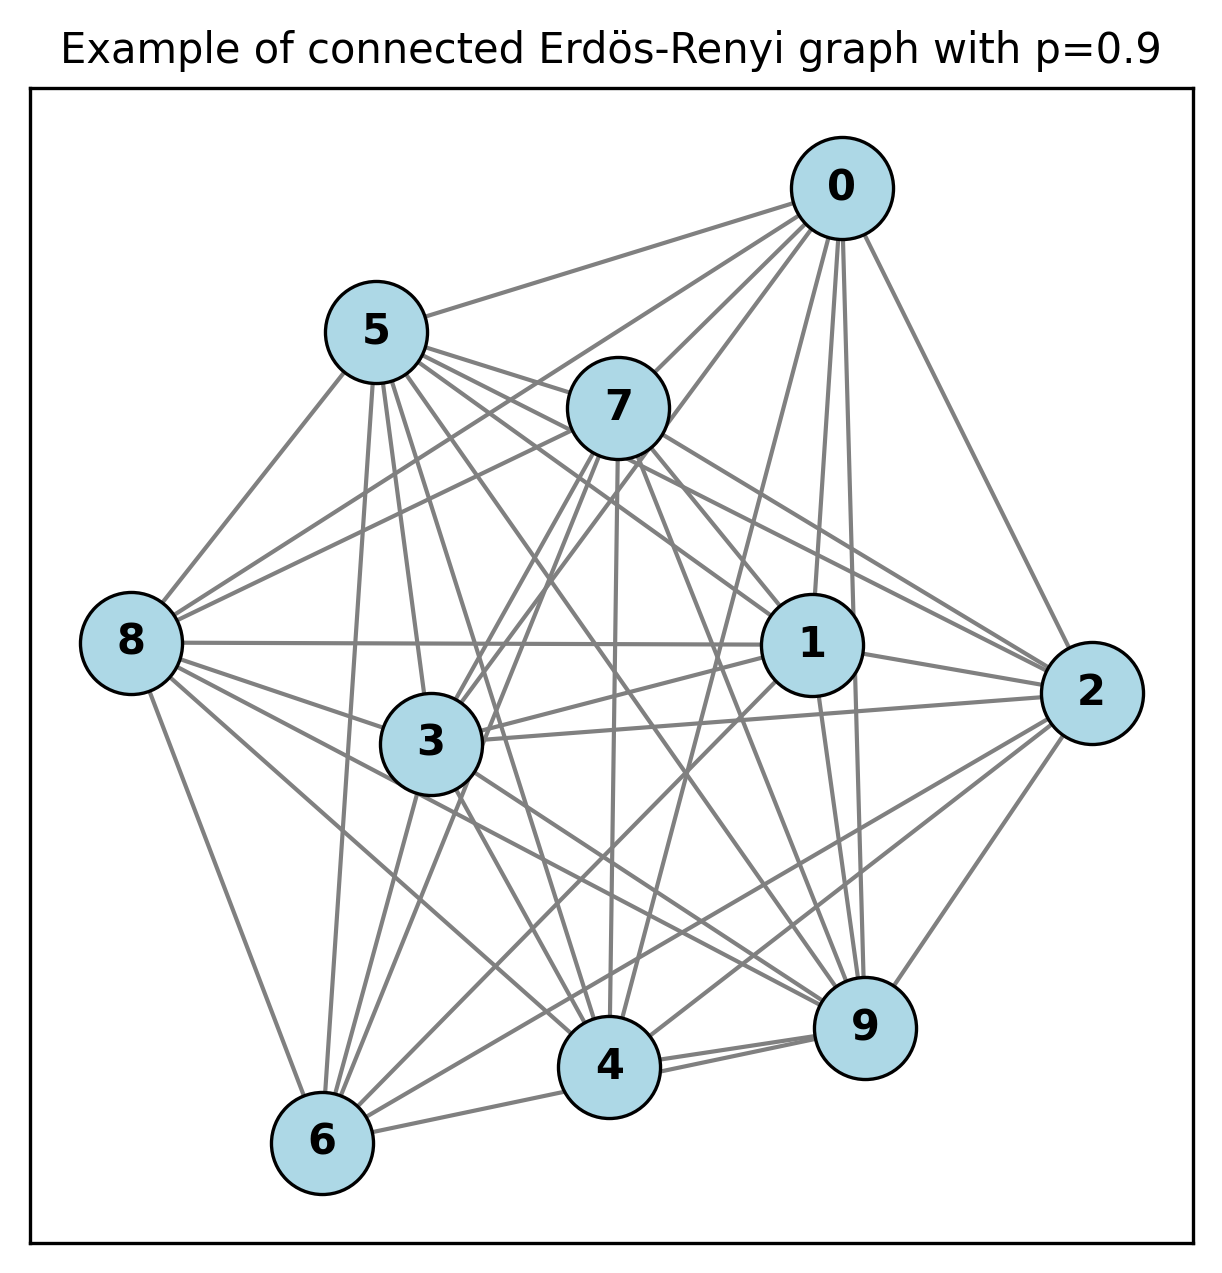

In [ ]:
G = generate_connected_graph(num_clients, graph_p[3], seed=42)
print(f"Second eigenvalue λ₂: {compute_lambda2(G):.4f}")

#nx.draw(G, with_labels=True, node_color='skyblue')
pos = nx.spring_layout(G)#, seed=42)
plt.figure(figsize=(5, 5), dpi=300)
nx.draw_networkx_nodes(G, pos, node_size=600, node_color="lightblue", edgecolors="black", linewidths=0.8)
nx.draw_networkx_edges(G, pos, width=1.0, edge_color="gray")
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")

plt.title(f"Example of connected Erdös-Renyi graph with p={graph_p[3]}", fontsize=10)
plt.show()

In [ ]:
for p in [0.1, 0.6, 0.9]:
  print(f"Start training graph_connectivity: p = {p}")
  G = generate_connected_graph(num_clients, p, seed=42)
  W = build_metropolis_matrix(G)

  for i in range(len(chan_sd)):
    print(f"Start training for chan std {chan_sd[i]} and noise std {noise_sd[i]}")
    distr_acc, distr_loss_ = training_Distributed_FedAvg_OTA(comms_round, lr, loss, model_fn,
                                                            clients_batched, test_batched,
                                                            adjacency_matrix=W,
                                                            chan_std=float(chan_sd[i]), noise_std=float(noise_sd[i]))
    write_results_to_txt_file(f'file_out_eurosat_distr_{str(p).replace(".","")}_acc_{chan_sd[i].replace(".","")}_{noise_sd[i].replace(".","")}',
                              distr_acc, out_path)
    write_results_to_txt_file(f'file_out_eurosat_distr_{str(p).replace(".","")}_loss_{chan_sd[i].replace(".","")}_{noise_sd[i].replace(".","")}',
                              distr_loss_, out_path)

### Accuracy comparison plots

In [ ]:
ls_map = {0.1: '--'}
marker_map = {0.3: '|'}
lw_map = {0.9: 2}

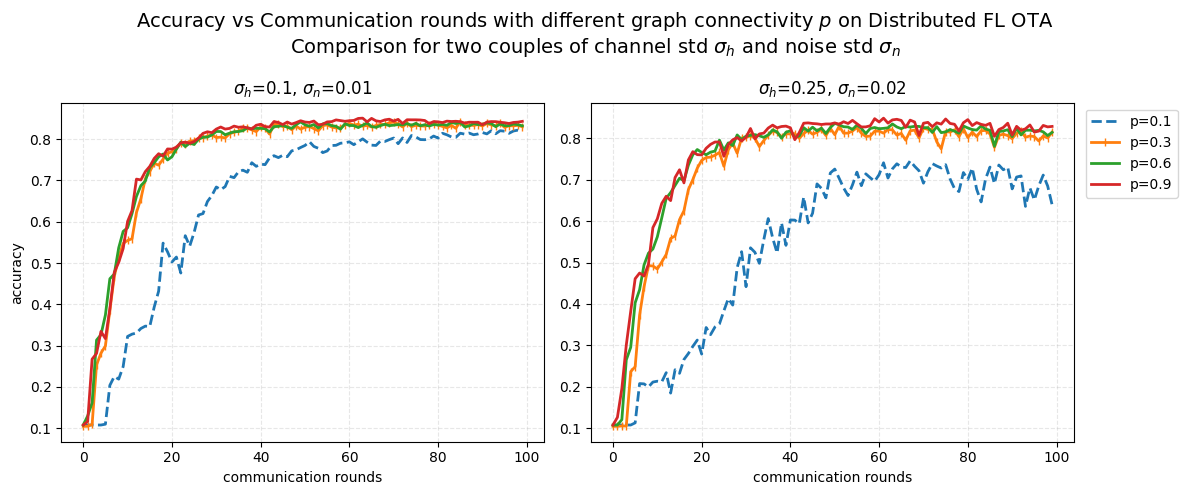

In [ ]:
plt.figure(figsize=(12,5))
plt.suptitle(r'Accuracy vs Communication rounds with different graph connectivity $p$ on Distributed FL OTA' '\n'
             r'Comparison for two couples of channel std $\sigma_h$ and noise std $\sigma_n$',
             fontsize=14, y=0.98)

plt.subplot(1,2,1) # sigma_h=0.1, sigma_n=0.01
for p in graph_p:
  distr_acc = read_results_from_txt_file(f'file_out_eurosat_distr_{str(p).replace(".", "")}_acc_01_001', out_path)
  lets_plot(distr_acc, label=f"p={p}", title=fr"$\sigma_h$=0.1, $\sigma_n$=0.01", ylabel="accuracy",
            lnstl=ls_map.get(p, '-'), marker=marker_map.get(p, None), lw=lw_map.get(p, 2))

plt.subplot(1,2,2) # sigma_h=0.25, sigma_n=0.02
for p in graph_p:
  distr_acc = read_results_from_txt_file(f'file_out_eurosat_distr_{str(p).replace(".", "")}_acc_025_002', out_path)
  lets_plot(distr_acc, label=f"p={p}", title=fr"$\sigma_h$=0.25, $\sigma_n$=0.02",
            lnstl=ls_map.get(p, '-'), marker=marker_map.get(p, None), lw=lw_map.get(p, 2))

plt.legend(loc='upper right', bbox_to_anchor=(1.23, 1.0))
#plt.subplots_adjust(right=0.82)
plt.tight_layout()
save_plot(plot_path, 'distrErdosR')
plt.show()

To study the correlation between accuracy and graph density, try case of distristributed FL with channel and noise std almost zero.

In [ ]:
for p in graph_p:
  G = generate_connected_graph(num_clients, p, seed=42)
  W = build_metropolis_matrix(G)
  print(f"Start training graph_connectivity: p = {p}")

  distr_acc, distr_loss_ = training_Distributed_FedAvg_OTA(comms_round, lr, loss, model_fn,
                                                            clients_batched, test_batched,
                                                            adjacency_matrix=W,
                                                            chan_std=1e-12, noise_std=1e-12)

  write_results_to_txt_file(f'file_out_eurosat_distr_{str(p).replace(".","")}_acc_FL', distr_acc, out_path)
  write_results_to_txt_file(f'file_out_eurosat_distr_{str(p).replace(".","")}_loss_FL', distr_loss_, out_path)

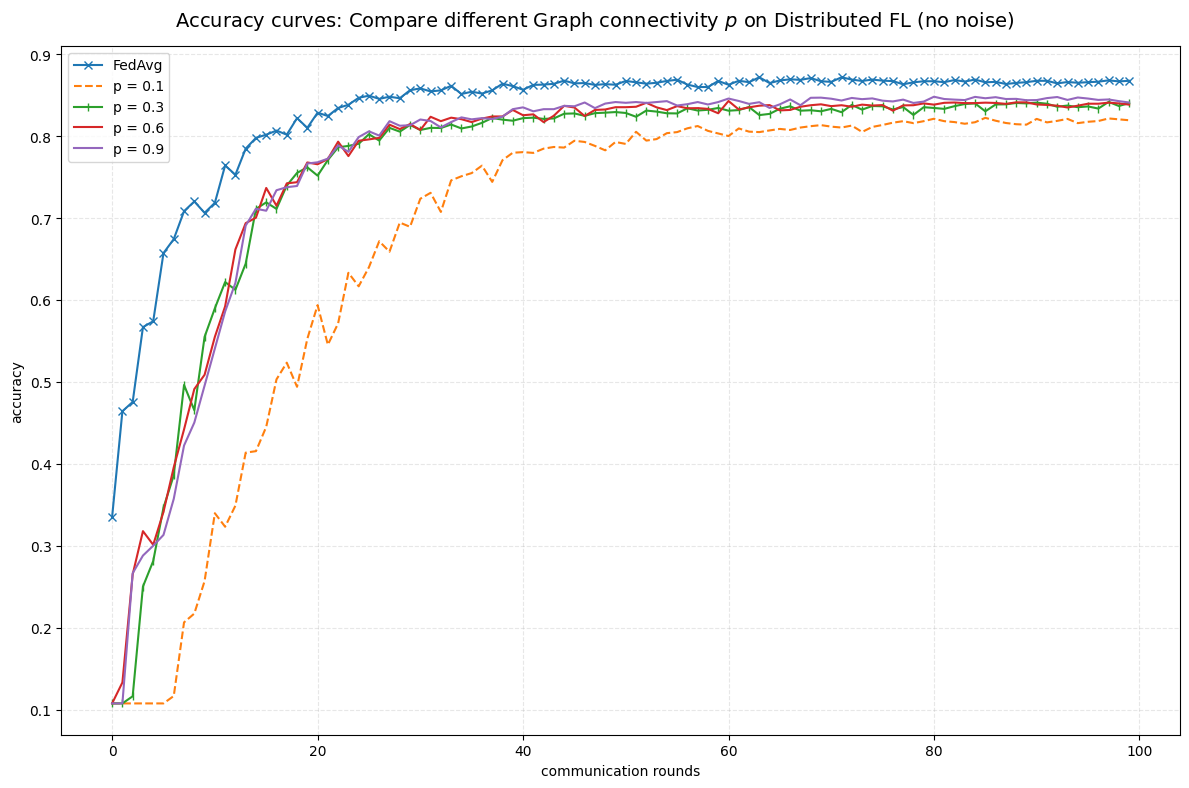

In [ ]:
plt.figure(figsize=(12,8))
plt.suptitle(fr"Accuracy curves: Compare different Graph connectivity $p$ on Distributed FL (no noise)", fontsize=14)

acc_ = read_results_from_txt_file(f'file_out_eurosat_acc_fl', out_path)
lets_plot(acc_, label='FedAvg', marker='x')

for p in graph_p:
  distr_acc = read_results_from_txt_file(f'file_out_eurosat_distr_{str(p).replace(".", "")}_acc_FL', out_path)
  lets_plot(distr_acc, label=f"p = {p}", title="", ylabel="accuracy", lnstl=ls_map.get(p, '-'), marker=marker_map.get(p, None))
plt.legend()
save_plot(plot_path, 'distrErdosR_nonoise')
plt.show()

Per valutare l’effetto della connettività del grafo sulla velocità di convergenza, non è stata considerata direttamente l’accuratezza del modello, bensì l’errore di consenso, definito come **la distanza media dei pesi locali rispetto alla media globale dei modelli**. Tale metrica è comunemente utilizzata negli studi sul consensus distribuito, in quanto isola il fenomeno di allineamento tra i client indipendentemente dalla capacità predittiva del modello.

In questo modo è possibile osservare chiaramente che grafi con valori più elevati di $\lambda_2$
  (maggiore connettività) portano ad una rapida diminuzione dell’errore rispetto alla media, evidenziando una convergenza molto più veloce. Al contrario, topologie scarsamente connesse, caratterizzate da valori bassi di $\lambda_2$
, mostrano un calo lento e prolungato dell’errore di consenso.

In [ ]:
def simulate_consensus(W, x0, steps):
  x = x0.clone()
  history = [x.numpy()]
  for _ in range(steps):
    x = W @ x
    history.append(x.numpy())
  return np.stack(history)

In [ ]:
def convergence_error(trajectory):
  mean = trajectory[-1].mean()
  return np.linalg.norm(trajectory - mean, axis=1)

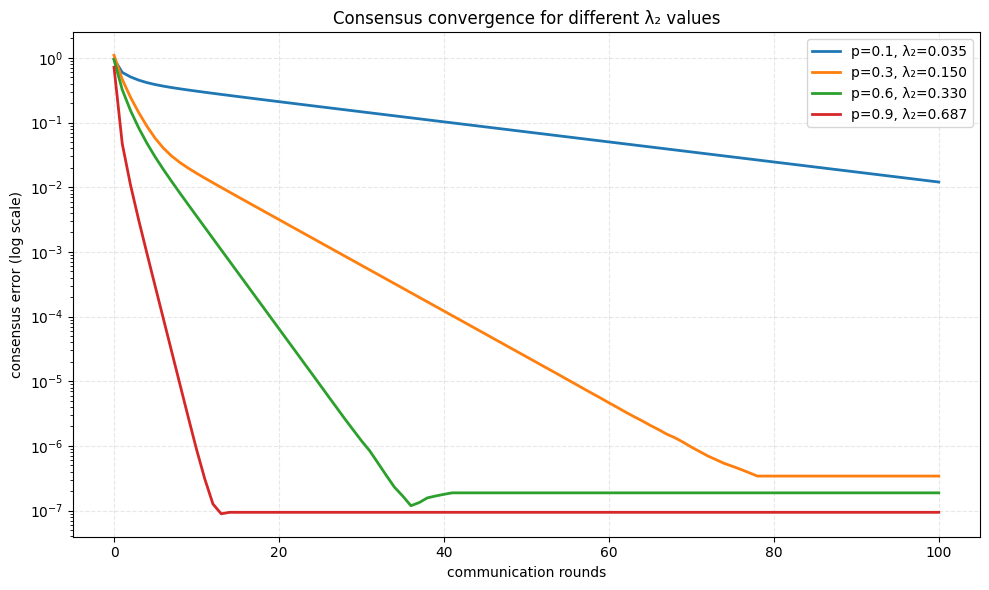

In [ ]:
plt.figure(figsize=(10,6))
for p in graph_p:
  G = generate_connected_graph(num_clients, p, seed=42)

  # compute W and simulate consensus
  W = build_metropolis_matrix(G)
  x0 = torch.rand(num_clients)
  traj = simulate_consensus(W, x0, comms_round)
  err = convergence_error(traj)

  # compute second eigenvalue of Laplacian
  lambda2 = compute_lambda2(G)

  plt.plot(err, label=f"p={p}, λ₂={lambda2:.3f}", linewidth=2)
plt.yscale('log')
plt.xlabel("communication rounds")
plt.ylabel("consensus error (log scale)")
plt.title("Consensus convergence for different λ₂ values")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

## Training non-random topologies


In [ ]:
def generate_structured_graph(num_nodes, topology):
  # ring (cicle) graph: each node i connected to (i-1) and (i+1) mod n
  if topology == 'ring':
    G = nx.cycle_graph(num_nodes)
  # path (line) graph: nodes 0-1-2-...-(n-1)
  elif topology == 'line':
    G = nx.path_graph(num_nodes)
  elif topology == 'star':
    G = nx.star_graph(num_nodes-1)
  # complete graph: every node connected to every other node
  elif topology == 'complete':
    G = nx.complete_graph(num_nodes)
  elif topology == 'circulant':
    G = nx.circulant_graph(num_nodes, [1, 2, 4])
  elif topology == 'mesh':
    G = nx.grid_2d_graph(2, 5)  # 2 rows, 5 cols, 10 nodes
    G = nx.convert_node_labels_to_integers(G)
  else: raise ValueError(f"Invalid topology: {topology}")

  return G

In [ ]:
topology = ['ring', 'line', 'star', 'complete', 'circulant', 'mesh']

ring: λ₂=0.8727, gap=0.1273


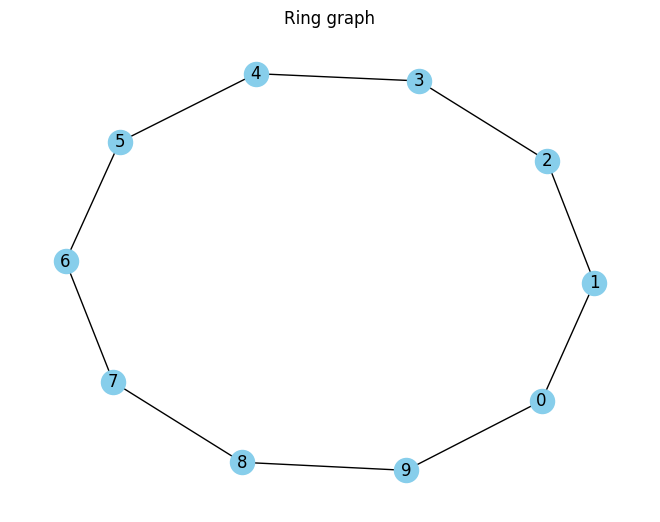

In [ ]:
nx.draw(generate_structured_graph(num_clients, topology[0]), with_labels=True, node_color='skyblue')
plt.title('Ring graph')
lambda2, gap = spectral_gap(build_metropolis_matrix(generate_structured_graph(num_clients, topology[0])))
print(f"{topology[0]}: λ₂={lambda2:.4f}, gap={gap:.4f}")
plt.show()

line: λ₂=0.9674, gap=0.0326


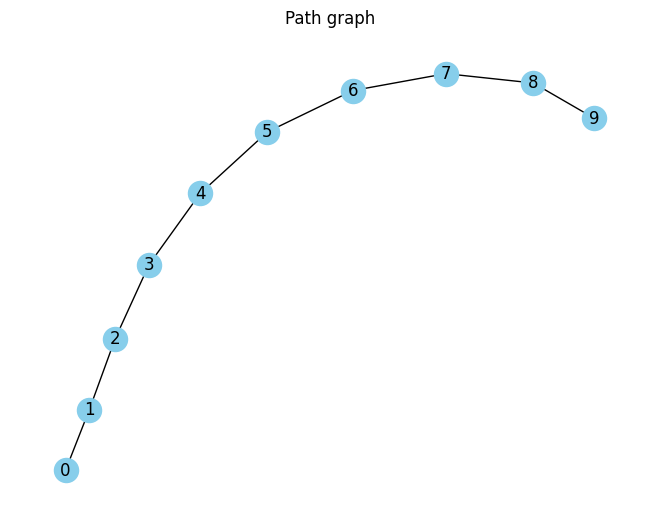

In [ ]:
nx.draw(generate_structured_graph(num_clients, topology[1]), with_labels=True, node_color='skyblue')
plt.title('Path graph')
lambda2, gap = spectral_gap(build_metropolis_matrix(generate_structured_graph(num_clients, topology[1])))
print(f"{topology[1]}: λ₂={lambda2:.4f}, gap={gap:.4f}")
plt.show()

star: λ₂=0.9000, gap=0.1000


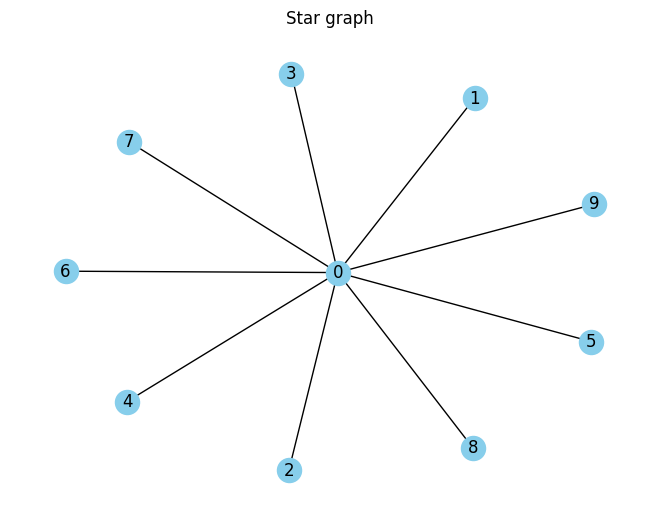

In [ ]:
nx.draw(generate_structured_graph(num_clients, topology[2]), with_labels=True, node_color='skyblue')
plt.title('Star graph')
lambda2, gap = spectral_gap(build_metropolis_matrix(generate_structured_graph(num_clients, topology[2])))
print(f"{topology[2]}: λ₂={lambda2:.4f}, gap={gap:.4f}")
plt.show()

complete: λ₂=0.0000, gap=1.0000


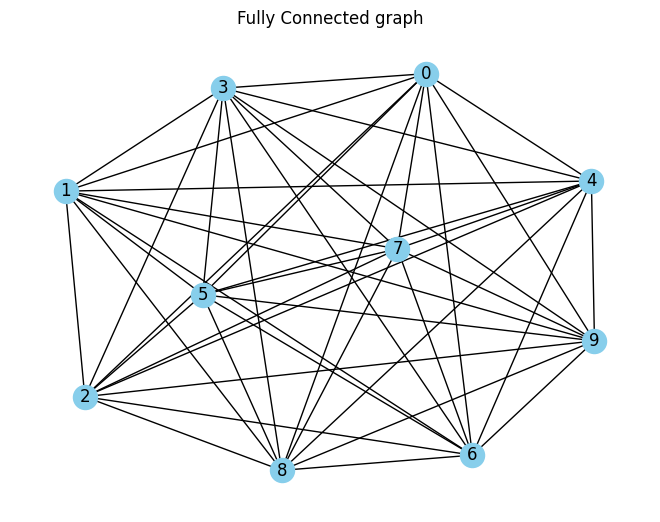

In [ ]:
nx.draw(generate_structured_graph(num_clients, topology[3]), with_labels=True, node_color='skyblue')
plt.title('Fully Connected graph')
lambda2, gap = spectral_gap(build_metropolis_matrix(generate_structured_graph(num_clients, topology[3])))
print(f"{topology[3]}: λ₂={lambda2:.4f}, gap={gap:.4f}")
plt.show()

circulant: λ₂=0.4286, gap=0.5714


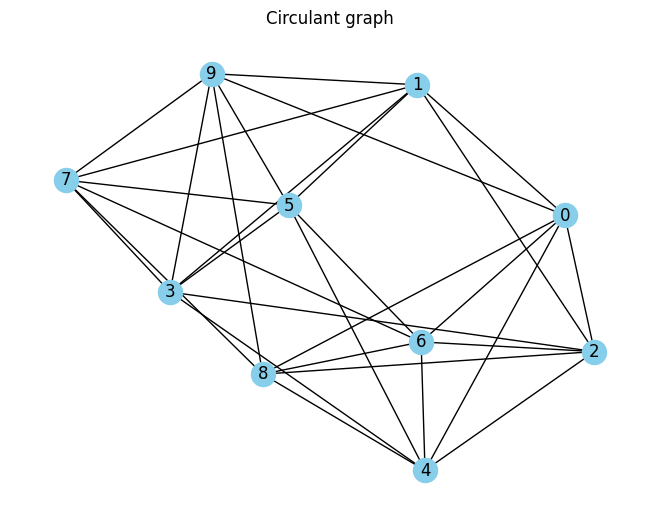

In [ ]:
nx.draw(generate_structured_graph(num_clients, topology[4]), with_labels=True, node_color='skyblue')
plt.title('Circulant graph')
lambda2, gap = spectral_gap(build_metropolis_matrix(generate_structured_graph(num_clients, topology[4])))
print(f"{topology[4]}: λ₂={lambda2:.4f}, gap={gap:.4f}")
plt.show()

mesh: λ₂=0.9045, gap=0.0955


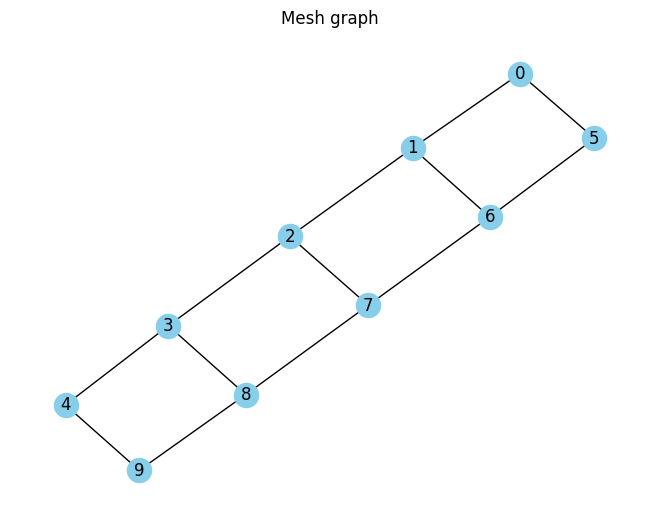

In [ ]:
nx.draw(generate_structured_graph(num_clients, topology[5]), with_labels=True, node_color='skyblue')
plt.title('Mesh graph')
lambda2, gap = spectral_gap(build_metropolis_matrix(generate_structured_graph(num_clients, topology[5])))
print(f"{topology[5]}: λ₂={lambda2:.4f}, gap={gap:.4f}")
plt.show()

- Train and plot distributed case (almost) noiseless

In [ ]:
for topo in topology:
  G = generate_structured_graph(num_clients, topo)
  W = build_metropolis_matrix(G)
  print(f"Start training {topo} graph")
  acc_, loss_ = training_Distributed_FedAvg_OTA(comms_round, lr, loss, model_fn,
                                                clients_batched, test_batched,
                                                W, chan_std=1e-12 , noise_std=1e-12)
  write_results_to_txt_file(f'file_out_eurosat_distr_{topo}_acc_FL', acc_, out_path)
  write_results_to_txt_file(f'file_out_eurosat_distr_{topo}_loss_FL', loss_, out_path)

In [ ]:
ls_map = {'line': '--'}
marker_map = {'star': 'x', 'complete':'|', 'ring':'o'}
markevery_map = {'ring': 5, 'star': 5}
lw_map = {'line': 2}

In [ ]:
plt.figure(figsize=(12,8))
plt.suptitle('Comparison of Centralized and structured Distributed FL topologies'
             '\n' '(no noise case)',
             fontsize=14)

centr_acc = read_results_from_txt_file(f'file_out_eurosat_acc_fl', out_path)
lets_plot(centr_acc, label='Centralized FL', ylabel='accuracy', lw=2)

for topo in topology:
  acc_ = read_results_from_txt_file(f'file_out_eurosat_distr_{topo}_acc_FL', out_path)
  lets_plot(acc_, label=f"Distributed FL: {topo}", ylabel="accuracy",
            lnstl=ls_map.get(topo, '-'), marker=marker_map.get(topo, None), markevery=markevery_map.get(topo, None),
            lw=lw_map.get(topo, 2) )
plt.legend(fontsize=10)
plt.show()

Train and plot structured distributed FL OTA with channel and noise std:
- $\sigma_h=0.1$, $\sigma_n=0.01$
- $\sigma_h=0.25$, $\sigma_n=0.02$

In [ ]:
chan_sd = ['0.1', '0.25', '0.2']
noise_sd = ['0.01', '0.02', '0.0175']

In [ ]:
topology

['ring', 'line', 'star', 'complete', 'circulant', 'mesh']

In [ ]:
for topo in topology:
  G = generate_structured_graph(num_clients, topo)
  W = build_metropolis_matrix(G)

  for i in range(len(chan_sd)):
    print(f"Start training for chan std {chan_sd[i]} and noise std {noise_sd[i]} for {topo} graph")
    distr_acc, distr_loss_ = training_Distributed_FedAvg_OTA(comms_round, lr, loss, model_fn,
                                                            clients_batched, test_batched, W,
                                                            chan_std=float(chan_sd[i]), noise_std=float(noise_sd[i]))
    write_results_to_txt_file(f'file_out_eurosat_distr_{topo}_acc_{chan_sd[i].replace(".","")}_{noise_sd[i].replace(".","")}',
                              distr_acc, out_path)
    write_results_to_txt_file(f'file_out_eurosat_distr_{topo}_loss_{chan_sd[i].replace(".","")}_{noise_sd[i].replace(".","")}',
                              distr_loss_, out_path)

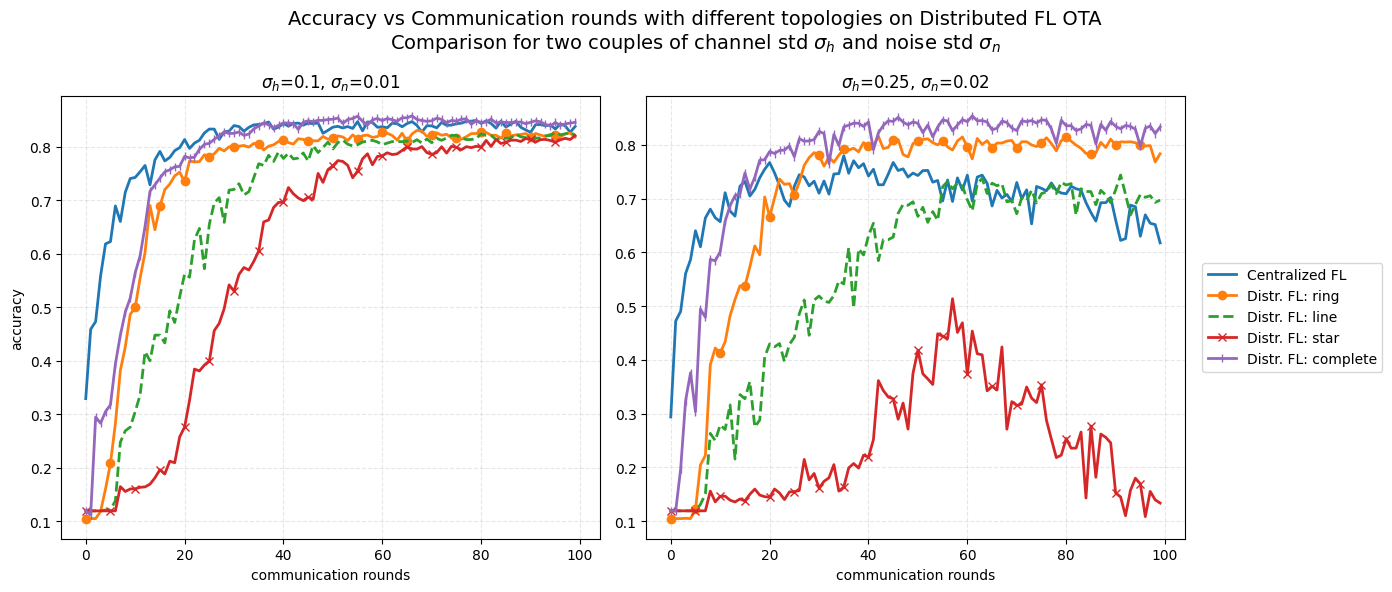

In [ ]:
topology = ['ring', 'line', 'star', 'complete']
plt.figure(figsize=(14,6))
plt.suptitle(r'Accuracy vs Communication rounds with different topologies on Distributed FL OTA' '\n'
             r'Comparison for two couples of channel std $\sigma_h$ and noise std $\sigma_n$',
             fontsize=14, y=0.98)

plt.subplot(1,2,1) # sigma_h=0.1, sigma_n=0.01
centr_acc = read_results_from_txt_file(f'file_out_eurosat_acc_01_001', out_path)
lets_plot(centr_acc, label='Centralized FL', ylabel='accuracy', lw=2)

for topo in topology:
  distr_acc = read_results_from_txt_file(f'file_out_eurosat_distr_{topo}_acc_01_001', out_path)
  lets_plot(distr_acc, label=f"Distr. FL: {topo}", title=fr"$\sigma_h$=0.1, $\sigma_n$=0.01", ylabel="accuracy",
            lnstl=ls_map.get(topo, '-'), marker=marker_map.get(topo, None), markevery=markevery_map.get(topo, None),
            lw=lw_map.get(topo, 2) )

plt.subplot(1,2,2) # sigma_h=0.25, sigma_n=0.02
centr_acc = read_results_from_txt_file(f'file_out_eurosat_acc_025_002', out_path)
lets_plot(centr_acc, label='Centralized FL', ylabel='accuracy', lw=2)

for topo in topology:
  distr_acc = read_results_from_txt_file(f'file_out_eurosat_distr_{topo}_acc_025_002', out_path)
  lets_plot(distr_acc, label=f"Distr. FL: {topo}", title=fr"$\sigma_h$=0.25, $\sigma_n$=0.02",
            lnstl=ls_map.get(topo, '-'), marker=marker_map.get(topo, None), markevery=markevery_map.get(topo, None),
            lw=lw_map.get(topo, 2) )

plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=10, frameon=True)
plt.subplots_adjust(right=0.78)
plt.tight_layout()
#save_plot(plot_path, 'distrtopo')
plt.show()

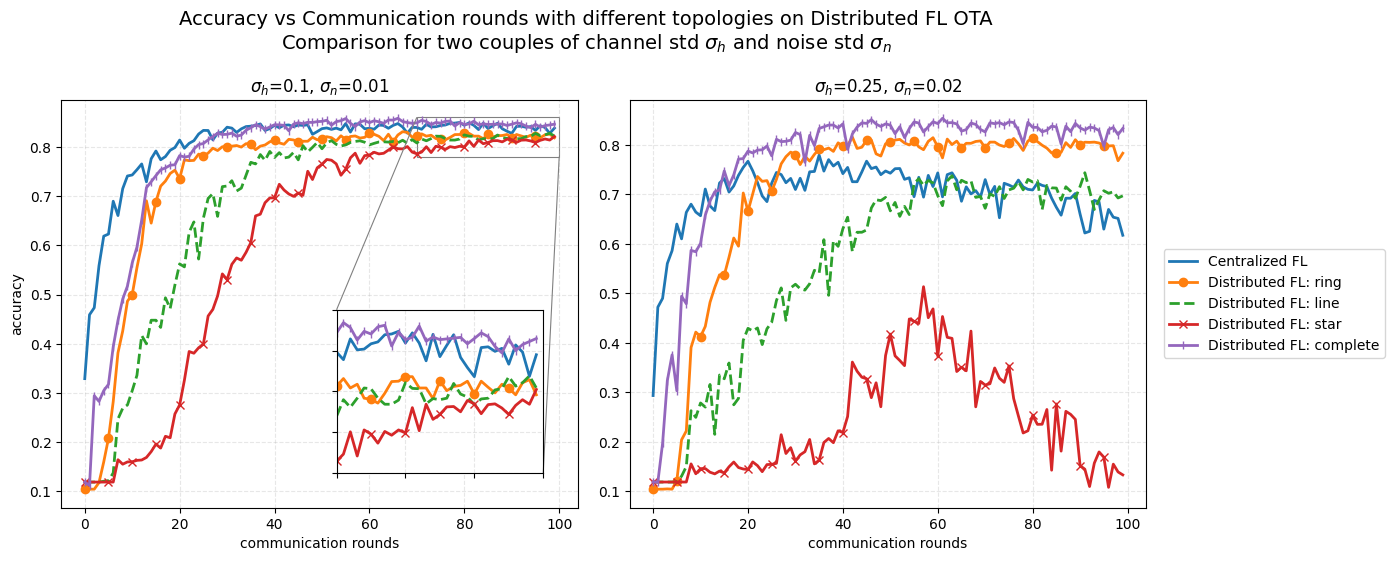

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

plt.figure(figsize=(14,6))
plt.suptitle(r'Accuracy vs Communication rounds with different topologies on Distributed FL OTA' '\n'
             r'Comparison for two couples of channel std $\sigma_h$ and noise std $\sigma_n$',
             fontsize=14, y=0.98)

ax1 = plt.subplot(1,2,1) # sigma_h=0.1, sigma_n=0.01
centr_acc = read_results_from_txt_file(f'file_out_eurosat_acc_01_001', out_path)
lets_plot(centr_acc, label='Centralized FL', ylabel='accuracy', lw=2)

for topo in topology:
  distr_acc = read_results_from_txt_file(f'file_out_eurosat_distr_{topo}_acc_01_001', out_path)
  lets_plot(distr_acc, label=f"Distributed FL: {topo}", title=fr"$\sigma_h$=0.1, $\sigma_n$=0.01", ylabel="accuracy",
            lnstl=ls_map.get(topo, '-'), marker=marker_map.get(topo, None), markevery=markevery_map.get(topo, None),
            lw=lw_map.get(topo, 2) )
axins = inset_axes(ax1, width="40%", height="40%", loc='lower right', borderpad=2.5)
lets_plot(centr_acc, lw=2)
for topo in topology:
  distr_acc = read_results_from_txt_file(f'file_out_eurosat_distr_{topo}_acc_01_001', out_path)
  lets_plot(distr_acc, lnstl=ls_map.get(topo, '-'), marker=marker_map.get(topo, None),
            markevery=markevery_map.get(topo, None), lw=lw_map.get(topo, 2) )
axins.set_xlim(70, 100)
axins.set_ylim(0.78, 0.86)
axins.tick_params(axis='x', which='both', labelbottom=False)
axins.tick_params(axis='y', which='both', labelleft=False)
axins.set_xlabel('')
axins.set_ylabel('')
mark_inset(ax1, axins, loc1=2, loc2=4, fc="none", ec="gray", lw=0.8)

ax2 = plt.subplot(1,2,2) # sigma_h=0.25, sigma_n=0.02
centr_acc = read_results_from_txt_file(f'file_out_eurosat_acc_025_002', out_path)
lets_plot(centr_acc, label='Centralized FL', ylabel='accuracy', lw=2)

for topo in topology:
  distr_acc = read_results_from_txt_file(f'file_out_eurosat_distr_{topo}_acc_025_002', out_path)
  lets_plot(distr_acc, label=f"Distributed FL: {topo}", title=fr"$\sigma_h$=0.25, $\sigma_n$=0.02",
            lnstl=ls_map.get(topo, '-'), marker=marker_map.get(topo, None), markevery=markevery_map.get(topo, None),
            lw=lw_map.get(topo, 2) )

plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=10, frameon=True)
plt.subplots_adjust(top=0.83, bottom=0.15, wspace=0.1)

#plt.tight_layout()
#save_plot(plot_path, 'distrtopo')
plt.show()

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

plt.figure(figsize=(14,6))
plt.suptitle(r'Accuracy vs Communication rounds with different topologies on Distributed FL OTA' '\n'
             r'Comparison for two couples of channel std $\sigma_h$ and noise std $\sigma_n$',
             fontsize=14, y=0.98)

ax1 = plt.subplot(1,2,1) # sigma_h=0.1, sigma_n=0.01
centr_acc = read_results_from_txt_file(f'file_out_eurosat_acc_01_001', out_path)
lets_plot(centr_acc, label='Centralized FL', ylabel='accuracy', lw=2)

for topo in topology:
  distr_acc = read_results_from_txt_file(f'file_out_eurosat_distr_{topo}_acc_01_001', out_path)
  lets_plot(distr_acc, label=f"Distributed FL: {topo}", title=fr"$\sigma_h$=0.1, $\sigma_n$=0.01", ylabel="accuracy",
            lnstl=ls_map.get(topo, '-'), marker=marker_map.get(topo, None), markevery=markevery_map.get(topo, None),
            lw=lw_map.get(topo, 2) )
axins = inset_axes(ax1, width="40%", height="40%", loc='lower right', borderpad=2.5)
lets_plot(centr_acc, lw=2)
for topo in topology:
  distr_acc = read_results_from_txt_file(f'file_out_eurosat_distr_{topo}_acc_01_001', out_path)
  lets_plot(distr_acc, lnstl=ls_map.get(topo, '-'), marker=marker_map.get(topo, None),
            markevery=markevery_map.get(topo, None), lw=lw_map.get(topo, 2) )
axins.set_xlim(70, 100)
axins.set_ylim(0.78, 0.86)
axins.tick_params(axis='x', which='both', labelbottom=False)
axins.tick_params(axis='y', which='both', labelleft=False)
axins.set_xlabel('')
axins.set_ylabel('')
mark_inset(ax1, axins, loc1=2, loc2=4, fc="none", ec="gray", lw=0.8)

ax2 = plt.subplot(1,2,2) # sigma_h=0.25, sigma_n=0.02
centr_acc = read_results_from_txt_file(f'file_out_eurosat_acc_02_00175', out_path)
lets_plot(centr_acc, label='Centralized FL', ylabel='accuracy', lw=2)

for topo in topology:
  distr_acc = read_results_from_txt_file(f'file_out_eurosat_distr_{topo}_acc_02_00175', out_path)
  lets_plot(distr_acc, label=f"Distributed FL: {topo}", title=fr"$\sigma_h$=0.2, $\sigma_n$=0.0175",
            lnstl=ls_map.get(topo, '-'), marker=marker_map.get(topo, None), markevery=markevery_map.get(topo, None),
            lw=lw_map.get(topo, 2) )

plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=10, frameon=True)
plt.subplots_adjust(top=0.83, bottom=0.15, wspace=0.1)

#plt.tight_layout()
#save_plot(plot_path, 'distrtopo')
plt.show()

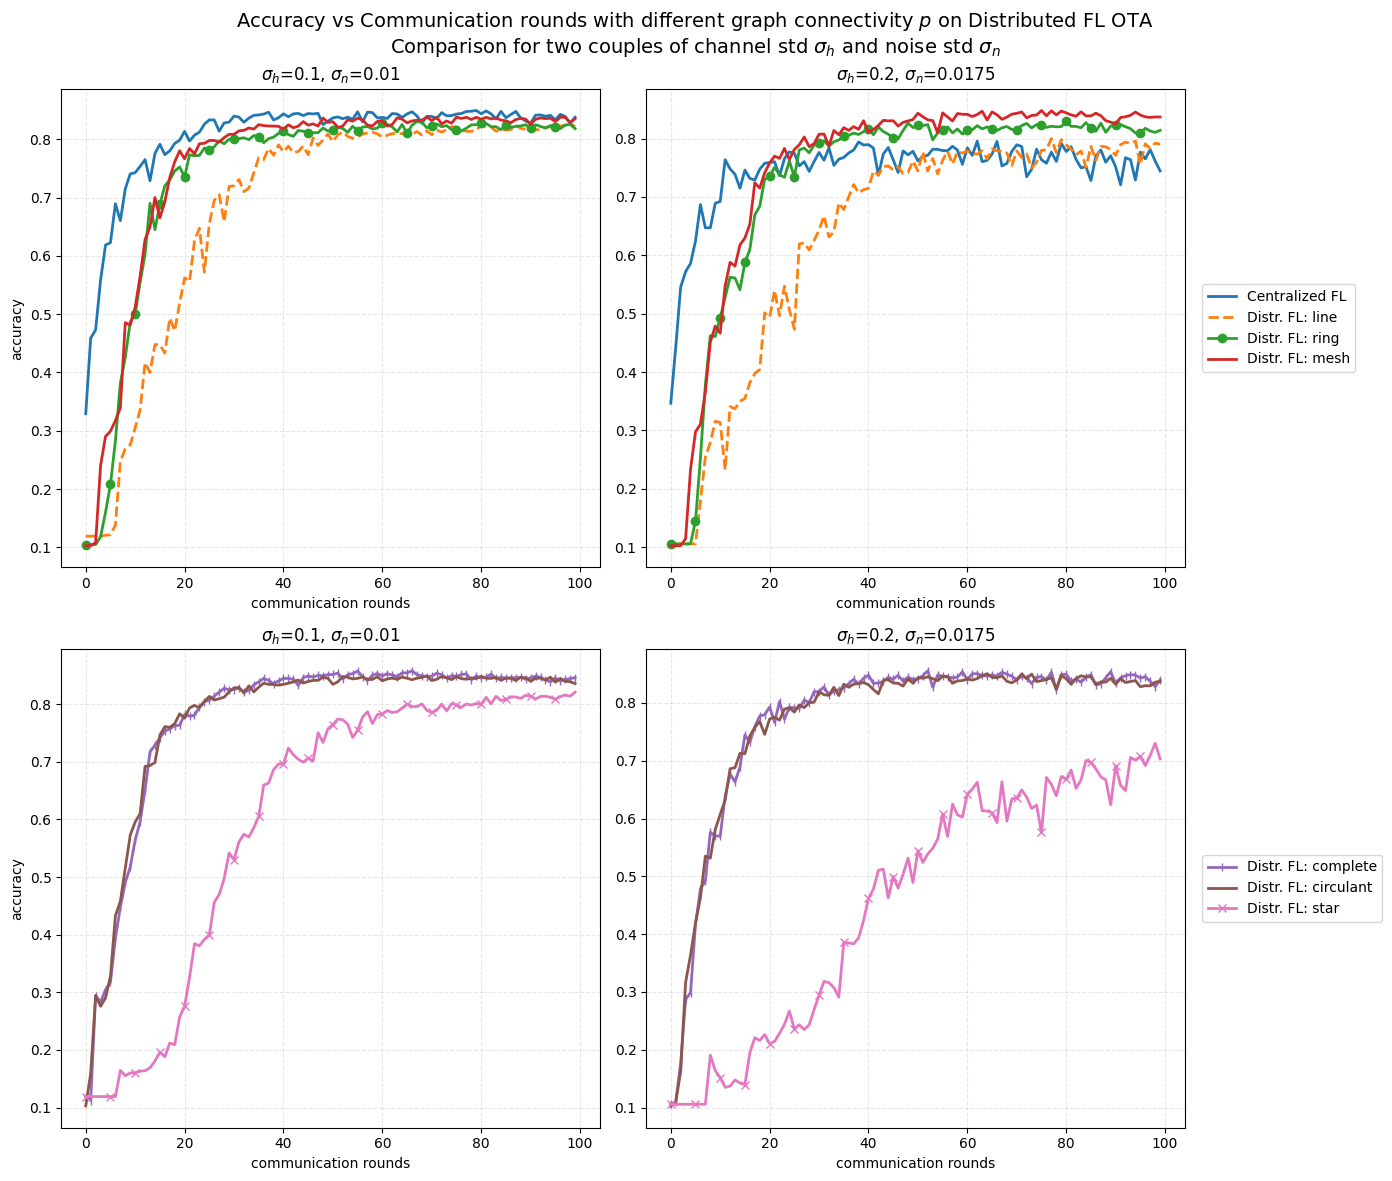

In [ ]:
from cycler import cycler
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
row1_colors   = default_colors[:4]
row2_colors   = default_colors[4:7]

plt.figure(figsize=(14,12))
plt.suptitle(r'Accuracy vs Communication rounds with different graph connectivity $p$ on Distributed FL OTA' '\n'
             r'Comparison for two couples of channel std $\sigma_h$ and noise std $\sigma_n$',
             fontsize=14, y=0.98)

ax1 = plt.subplot(2,2,1) # sigma_h=0.1, sigma_n=0.01
ax1.set_prop_cycle(cycler('color', row1_colors))
centr_acc = read_results_from_txt_file(f'file_out_eurosat_acc_01_001', out_path)
lets_plot(centr_acc, label='Centralized FL', ylabel='accuracy', lw=2)

for topo in ['line', 'ring', 'mesh']:
  distr_acc = read_results_from_txt_file(f'file_out_eurosat_distr_{topo}_acc_01_001', out_path)
  lets_plot(distr_acc, label=f"Distr. FL: {topo}", title=fr"$\sigma_h$=0.1, $\sigma_n$=0.01", ylabel="accuracy",
            lnstl=ls_map.get(topo, '-'), marker=marker_map.get(topo, None), markevery=markevery_map.get(topo, None),
            lw=lw_map.get(topo, 2) )

ax2 = plt.subplot(2,2,2) # sigma_h=0.2, sigma_n=0.0175
ax2.set_prop_cycle(cycler('color', row1_colors))
centr_acc = read_results_from_txt_file(f'file_out_eurosat_acc_02_00175', out_path)
lets_plot(centr_acc, label='Centralized FL', ylabel='accuracy', lw=2)

for topo in ['line', 'ring', 'mesh']:
  distr_acc = read_results_from_txt_file(f'file_out_eurosat_distr_{topo}_acc_02_00175', out_path)
  lets_plot(distr_acc, label=f"Distr. FL: {topo}", title=fr"$\sigma_h$=0.2, $\sigma_n$=0.0175",
            lnstl=ls_map.get(topo, '-'), marker=marker_map.get(topo, None), markevery=markevery_map.get(topo, None),
            lw=lw_map.get(topo, 2) )

plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=10, frameon=True)

ax3 = plt.subplot(2, 2, 3)
ax3.set_prop_cycle(cycler('color', row2_colors))
for topo in ['complete', 'circulant', 'star']:
  distr_acc = read_results_from_txt_file(f'file_out_eurosat_distr_{topo}_acc_01_001', out_path)
  lets_plot(distr_acc, label=f"Distr. FL: {topo}", title=fr"$\sigma_h$=0.1, $\sigma_n$=0.01", ylabel="accuracy",
            lnstl=ls_map.get(topo, '-'), marker=marker_map.get(topo, None), markevery=markevery_map.get(topo, None),
            lw=lw_map.get(topo, 2) )

ax4 = plt.subplot(2, 2, 4)
ax4.set_prop_cycle(cycler('color', row2_colors))
for topo in ['complete', 'circulant', 'star']:
  distr_acc = read_results_from_txt_file(f'file_out_eurosat_distr_{topo}_acc_02_00175', out_path)
  lets_plot(distr_acc, label=f"Distr. FL: {topo}", title=fr"$\sigma_h$=0.2, $\sigma_n$=0.0175",
            lnstl=ls_map.get(topo, '-'), marker=marker_map.get(topo, None), markevery=markevery_map.get(topo, None),
            lw=lw_map.get(topo, 2) )
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=10, frameon=True)

plt.subplots_adjust(right=0.78)
plt.tight_layout()
#save_plot(plot_path, 'distrtopo')
plt.show()